# Harry Neal - Spotify MoodGrid

*Spotify Moodgrid Playlist Subsetter is a tool to combine multiple playlists, give them a happy score and an energy score, and then output a new personal playlist centred around your chosen Happy/Energy mood.*

## Notebook 2 of 4 - Pre-Processing & Exploratory Data Analysis

### Data Dictionary

Column Name | Data Type | Description
------------|-----------|------------
track_id | string | Song unique ID
track_name | string | Song Name
artists | string | Song Artist or artists
popularity | integer | Song Popularity (0-100) where higher number equates to higher popularity
danceability | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
energy | float | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
key | integer | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
loudness | float | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
mode | integer | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
speechiness | float | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
acousticness | float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
instrumentalness | float | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
liveness | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
valence | float | 	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
tempo | float | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
duration_ms | integer | Duration of song in milliseconds
time_signature | integer | Number of beats per measure
explicit | boolean | Indicates whether the track contains explicit content
playlist_mood | string | Mood of playlist, one of 'happy', 'sad', 'energetic', 'chill'
query | string | Query used to search for playlist
playlist_name | string | Name of playlist

In [278]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.regression import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import pi
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import re
from collections import Counter
import joblib
import random
import warnings
warnings.filterwarnings('ignore')

Load cleaned data and reset index

In [279]:
df = joblib.load("./data/pickles/cleaned_train_df.pkl")
df.reset_index(inplace=True, drop=True)

### Analysis of Numerical Features across `playlist_mood`

To gain an initial sense of which features will be good indicators of certain moods, let's look at some histograms of the numerical columns.

First let's split the columns on numerical vs categorical, and split into four different dataframes based on mood

In [280]:
# which cols are numerical and which are categorical
num_col_list = list(df.select_dtypes("number").columns)
cat_col_list = list(df.select_dtypes("object").columns)
cat_col_list.extend(list(df.select_dtypes("bool").columns))

print("Numerical columns: \n", ',\n'.join(num_col_list))
print("")
print("Categorical columns: \n", ',\n'.join(cat_col_list))

df_num = df[num_col_list].copy()
df_cat = df[cat_col_list].copy()

# add mood back into numerical df for analysis

df_moodnum = df_num.join(df_cat['playlist_mood'])

# split by mood for plotting

df_happynum = df_moodnum[df_moodnum['playlist_mood'] == 'happy']
df_sadnum = df_moodnum[df_moodnum['playlist_mood'] == 'sad']
df_chillnum = df_moodnum[df_moodnum['playlist_mood'] == 'chill']
df_energynum = df_moodnum[df_moodnum['playlist_mood'] == 'energetic']

Numerical columns: 
 popularity,
danceability,
energy,
key,
loudness,
mode,
speechiness,
acousticness,
instrumentalness,
liveness,
valence,
tempo,
duration_ms,
time_signature

Categorical columns: 
 track_id,
track_name,
artists,
artist_genre,
query,
playlist_name,
playlist_mood,
explicit


Plot a histogram for every numerical column

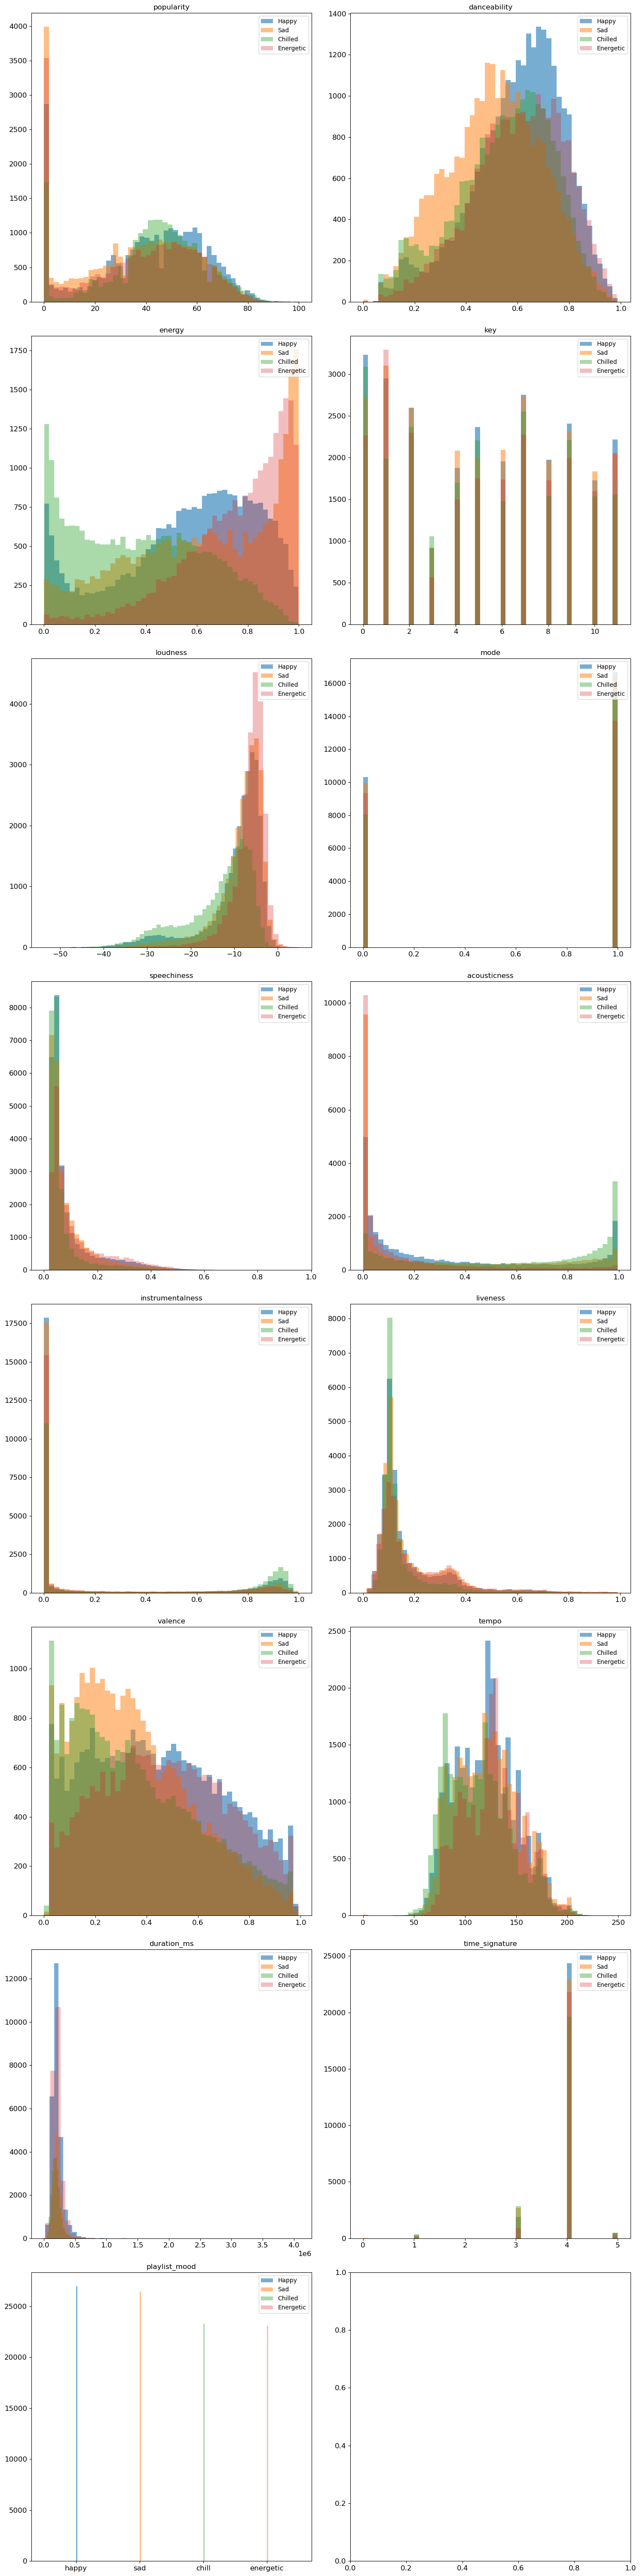

In [281]:
# Loop over the columns and plot the relationship between each column and the target
plt.subplots(8, 2, figsize=(15, 60))

count = 1



for col in df_moodnum.columns:
    plt.subplot(8, 2, count)
    plt.hist(df_happynum[col], bins=50, alpha=0.6, label='Happy', edgecolor='None')
    plt.hist(df_sadnum[col], bins=50, alpha=0.5, label='Sad', edgecolor='None')
    plt.hist(df_chillnum[col], bins=50, alpha=0.4, label='Chilled', edgecolor='None')
    plt.hist(df_energynum[col], bins=50, alpha=0.3, label='Energetic', edgecolor='None')
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    plt.legend(loc='upper right')
    plt.title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

- **Popularity**: The distributions are generally similar, with sad songs being skewed slightly towards lower popularity.
- **Danceability**: The peak of Happy and Sad is quite different, so this could be a good indicator of Happy songs.
- **Energy**: Energetic songs are heavily skewed towards the most energetic side of the scale, so this is likely to be a very good indicator of energetic songs.  Sad songs have a double peak in the distribution, one at energy= 1.0 and another at energy = 0.5.  This is possibly the presence of sad songs with 'angry/aggressive' energy, versus those with 'melancholy' energy.  A double peak can be also seen for Happy songs, with a peak at energy = 0.0 and at 0.7.  This is possibly due to the presence of 'Upbeat/Ecstatic' happy songs, and 'Blissful/Peaceful' happy songs.
- **Key**: Some differences can be seen in the key between moods, these will be investigated further later on.
- **Loudness**: The peak of Energetic is much higher loudness than Chilled, so this looks like it will be a good indicator of Energetic songs.
- **Mode**: Some differences can be seen in the mode, though they are hard to analyse at this scale.  These will be investigated further later on.
- **Speechiness**: Distributions are similar, with Energetic songs looking to be the most skewed to high speechiness.
- **Acousticness**: Has a bimodal distribution as the feature is predicting probability of song being acoustic.  From the distribution, chilled songs are more likely to be acoustic, so this could be a good indicator.
- **Instrumentalness**: Most songs are not instrumental, but of those that are, there is a difference between the moods.  Chilled songs have the highest peak at instrementalness of 1.0, followed by Happy, Sad and lastly Energetic.  Instrumentalness could therefore bne a good indicator for Energetic songs.
- **Liveness**: All moods have a double peak in the histogram, presumably where they are confidently not live (liveness=0.0), or where there may be an audience present (liveness~0.35).  Chilled songs have the lowest peak at liveness 0.35, so this could be a predictor of Energetic songs.
- **Valence**: Sad and Chilled songs both have peaks at lower valence, whereas Energetic and Happy songs have peaks at higher valence.  Therefore this could be a good predictor of both Happy songs and Energetic songs.
- **Tempo**: The distributions are similar for Energetic, Happy and Sad songs, with the peak of Chilled songs being at lower tempos.  This could therefore be a good predictor of Energetic songs.
- **Duration**: The differences in distributions are difficult to distinguish due to the presence of outliers.  This will be investigated next.
- **Time signature**: Some differences can be seen, though they are hard to analyse at this scale.  These will be investigated further later on.

Add a radar plot to summarise all of the above in a single visualisation

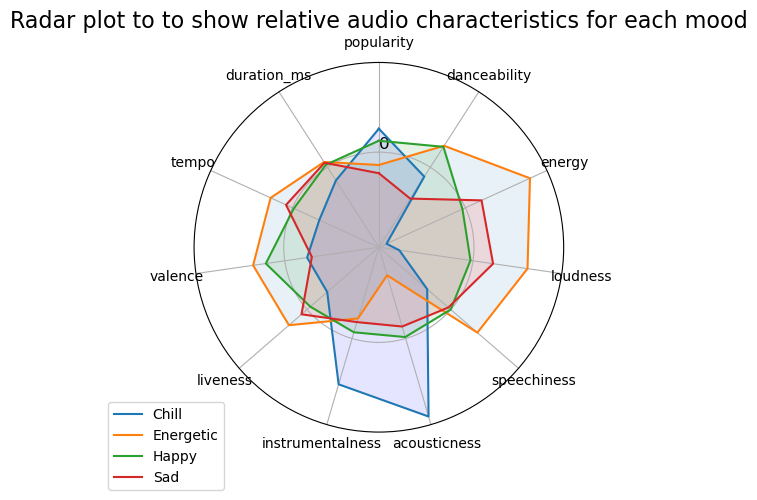

In [282]:
# drop non-continuous numerical features
df_radar = df_moodnum.drop(columns = ['key', 'mode', 'time_signature'])

# drop mood for array for scaling
df_radar_X = df_radar.drop(columns='playlist_mood')

radar_array  = np.array(df_radar_X)

# scale values with standard scaler
stdscaler = StandardScaler()
stdscaled = stdscaler.fit_transform(radar_array)

#convert back to dataframe
df_stdscaled_radar = pd.DataFrame(stdscaled, columns = df_radar_X.columns)

# add mood back in
df_stdscaled_radar = df_stdscaled_radar.join(df_radar['playlist_mood'])

df_stdscaled_means = df_stdscaled_radar.groupby('playlist_mood').mean().reset_index()

# Radar plot, using template: https://www.python-graph-gallery.com/radar-chart/

# Set data
radar_df = df_stdscaled_means
 
# ------- PART 1: Create background
 
# number of variables
categories=list(radar_df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, fontsize=10)

# Draw ylabels
ax.set_rlabel_position(0)
ax.set_yticks([-1,0,1])
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=radar_df.loc[0].drop('playlist_mood').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, linestyle='solid', label="Chill")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=radar_df.loc[1].drop('playlist_mood').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, linestyle='solid', label="Energetic")
ax.fill(angles, values, 'o', alpha=0.1)

# Ind3
values=radar_df.loc[2].drop('playlist_mood').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, linestyle='solid', label="Happy")
ax.fill(angles, values, 'g', alpha=0.1)

# Ind4
values=radar_df.loc[3].drop('playlist_mood').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, linestyle='solid', label="Sad")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Add title
plt.title("Radar plot to to show relative audio characteristics for each mood", loc='center', fontsize=16)

# Show the graph
plt.show()


The Radar plot above shows an overall summary of the audio features that at a glance can inform us on which are likely to be good predictors.
- High energy, loudness, speechiness for Energetic songs
- High acousticness & intrumentalness, low energy for Chill songs
- Valence, danceability, and to a lesser extent energy and loudness will help to distinguish between Happy and Sad songs.

#### Feature engineer `Genre` column

In [283]:
def print_NANs(dataframe):
    ''' print sum of NaNs in a dataframe if not zero'''
    nulls = dataframe.isna().sum()
    nulls_vals = list(nulls)
    nulls_keys = list(nulls.index)

    for i in range(len(nulls_keys)):
        if nulls_vals[i] > 0:
            print(f"{nulls_keys[i]} has {nulls_vals[i]} NaNs")

    if nulls.sum() == 0:
        print("There are no NaN values")
        

def print_value_counts(dataframe, column):
    vc = dataframe[column].value_counts()
    vc_index = list(vc.index)
    vc_counts = list(vc)
    for i in range(len(vc_counts)):
        print(f"Dataset contains {vc_counts[i]} {vc_index[i]} songs")

Check value counts

In [284]:
df['artist_genre'].value_counts()

[]                                                                       13113
[]                                                                        4272
[pop]                                                                     1059
['lo-fi beats']                                                           1045
[drift phonk]                                                              654
                                                                         ...  
['classic soundtrack', 'easy listening', 'light music', 'theme']             1
['pop r&b', 'pop rap']                                                       1
[alternative hip hop, indie jazz, indie soul]                                1
[nepali indie, nepali pop, tibetan pop]                                      1
['indonesian jazz', 'indonesian pop', 'indonesian singer-songwriter']        1
Name: artist_genre, Length: 12517, dtype: int64

The most common occurences in genre is a string of an empty list '[]', and an actual empty list [], which occurs when there is no artist genre present for a particular artist.  Whether it is a string of a list or a list is determined by whether it originated from the original data script or not.

The original workflow was done on genre as a string type, so in order for the flow to work on the new genres, convert everything to a string. 

In [285]:
df['artist_genre'] = df['artist_genre'].astype(str)

In [286]:
df['artist_genre'].value_counts()

[]                                                                            17385
['lo-fi beats']                                                                1435
['pop']                                                                        1075
['drift phonk']                                                                 657
['background piano']                                                            585
                                                                              ...  
['folk-pop', 'indiecoustica', 'stomp and holler']                                 1
['electropop', 'vapor pop', 'vapor soul']                                         1
['j-metal', 'j-poprock', 'j-rock', 'japanese post-hardcore', 'visual kei']        1
['dreamo', 'nz indie']                                                            1
['electro house', 'future bass', 'gaming edm']                                    1
Name: artist_genre, Length: 10566, dtype: int64

Genre is currently a long string of different genres, separated by commas, so let's separate each row into a list, divided by the comma

In [287]:
df['artist_genre'].iloc[3]

"['emo', 'midwest emo', 'sasscore', 'screamo', 'skramz', 'swedish emo']"

In [288]:
# get genre as a series
genre = df['artist_genre']

# split into a list using the comma
genre_split = genre.str.split(", ")

In [289]:
genre_split.iloc[3]

["['emo'",
 "'midwest emo'",
 "'sasscore'",
 "'screamo'",
 "'skramz'",
 "'swedish emo']"]

We have unwanted characters like '[]' and speech marks, so use regex to strip these out and convert to a list of lists

In [290]:
#strip out unwanted characters
new_genre_list = []

for artist in genre_split:
    strippedgenre = []
    for genre in artist:
        strippedgenre.append((re.sub(r'[^\w]', ' ', genre)).strip())
    new_genre_list.append(strippedgenre)

In [291]:
new_genre_list[3]

['emo', 'midwest emo', 'sasscore', 'screamo', 'skramz', 'swedish emo']

We now have a list of genres for every track in the dataframe, but these genres are very niche and there are thousands of different types.

Let's create a dictionary to keep track of each different genre and the number of times each one occurs

In [292]:
genre_counts = {}  # dictionary to keep track of genre counters

for genres in new_genre_list:
    # create a Counter for the current list of genres
    current_genre_count = Counter(genres)

    for genre, count in current_genre_count.items():
        # update the corresponding counter for the genre in the dictionary
        if genre in genre_counts:
            genre_counts[genre] += count
        else:
            genre_counts[genre] = count

In [293]:
print(f"There are {len(genre_counts)} different genres in the dataset")

There are 3477 different genres in the dataset


Sort the dictionary to find the most common genres

In [294]:
sorted_by_genre = sorted(genre_counts.items(), key=lambda x:x[1], reverse=True)
print(sorted_by_genre)

[('', 17385), ('pop', 10721), ('rap', 7515), ('dance pop', 5681), ('rock', 4933), ('hip hop', 4642), ('edm', 3658), ('alternative metal', 3583), ('pop rap', 3483), ('trap', 3164), ('pop dance', 2994), ('nu metal', 2739), ('classic rock', 2352), ('tropical house', 2311), ('modern rock', 2227), ('electro house', 2164), ('lo fi beats', 2109), ('mellow gold', 2002), ('indie pop', 1867), ('r b', 1852), ('soft rock', 1832), ('metalcore', 1812), ('southern hip hop', 1807), ('pop rock', 1741), ('post teen pop', 1712), ('metal', 1711), ('contemporary country', 1671), ('album rock', 1610), ('filmi', 1586), ('country', 1532), ('hard rock', 1457), ('underground hip hop', 1446), ('melodic metalcore', 1441), ('melodic rap', 1375), ('neo mellow', 1336), ('electropop', 1298), ('country road', 1261), ('dark trap', 1202), ('adult standards', 1154), ('canadian pop', 1147), ('screamo', 1115), ('alt z', 1104), ('folk rock', 1090), ('post grunge', 1020), ('alternative rock', 998), ('country rock', 997), ('p

Remove the empty genre ''

In [295]:
sorted_by_genre.pop(0)

('', 17385)

Create a genre list and corresponding count list for plotting

In [296]:
genre_name_list = []
genre_count_list = []

for i in range(len(sorted_by_genre)):
    genre_name_list.append(sorted_by_genre[i][0])
    genre_count_list.append(sorted_by_genre[i][1])

# create a subset for plotting some on a chart
genre_sparser_list = genre_name_list[0::100]

Plot the counts of all genres on a bar chart

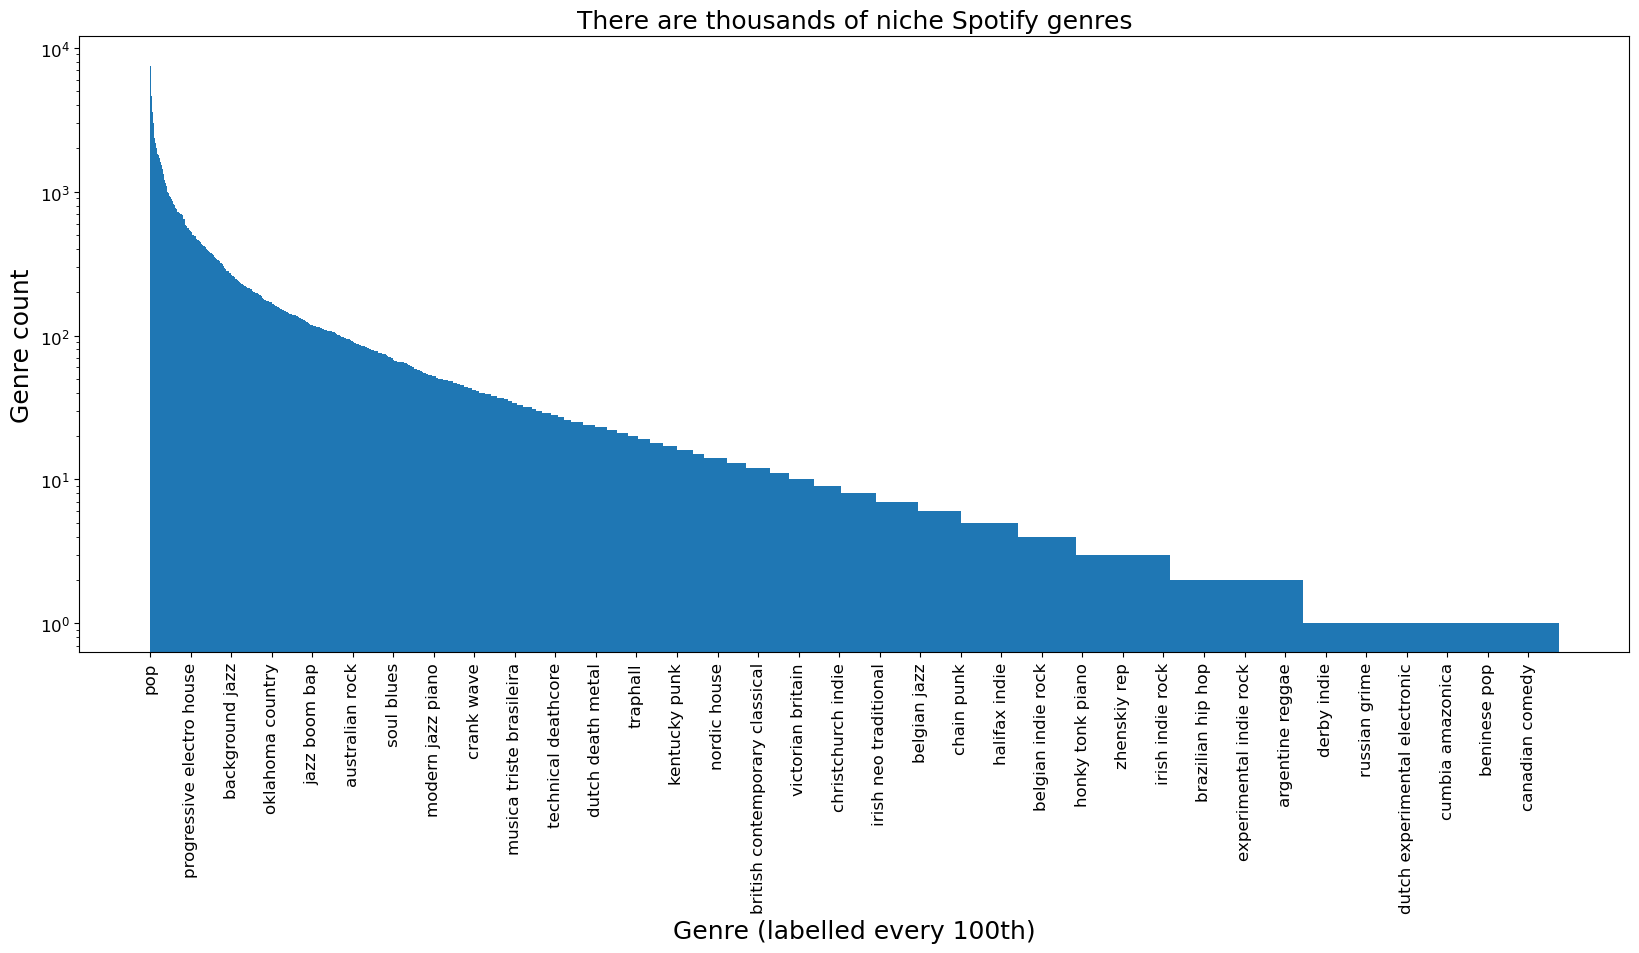

In [297]:
plt.figure(figsize=(20,8))
plt.bar(genre_name_list,genre_count_list, align='center',width=1.0,edgecolor='none')
plt.xticks(genre_sparser_list, rotation=90)
plt.title('There are thousands of niche Spotify genres', fontsize=18)
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.ylabel("Genre count", fontsize=18)
plt.xlabel("Genre (labelled every 100th)", fontsize=18)
plt.yscale(value='log')
plt.ylim(0, 12000)
plt.show()

The bar chart, with genre labelled every 100, illustrates just how many genres and sub-genres there are.  If we were to create dummy variables for all of these genres, then the number of features would begin to become unmanageable, and there would be minimal information contained with each one.

This leads us to the conclusion that we should attempt to further group genre into higher levels categories.

Plot the top 25 genres only 

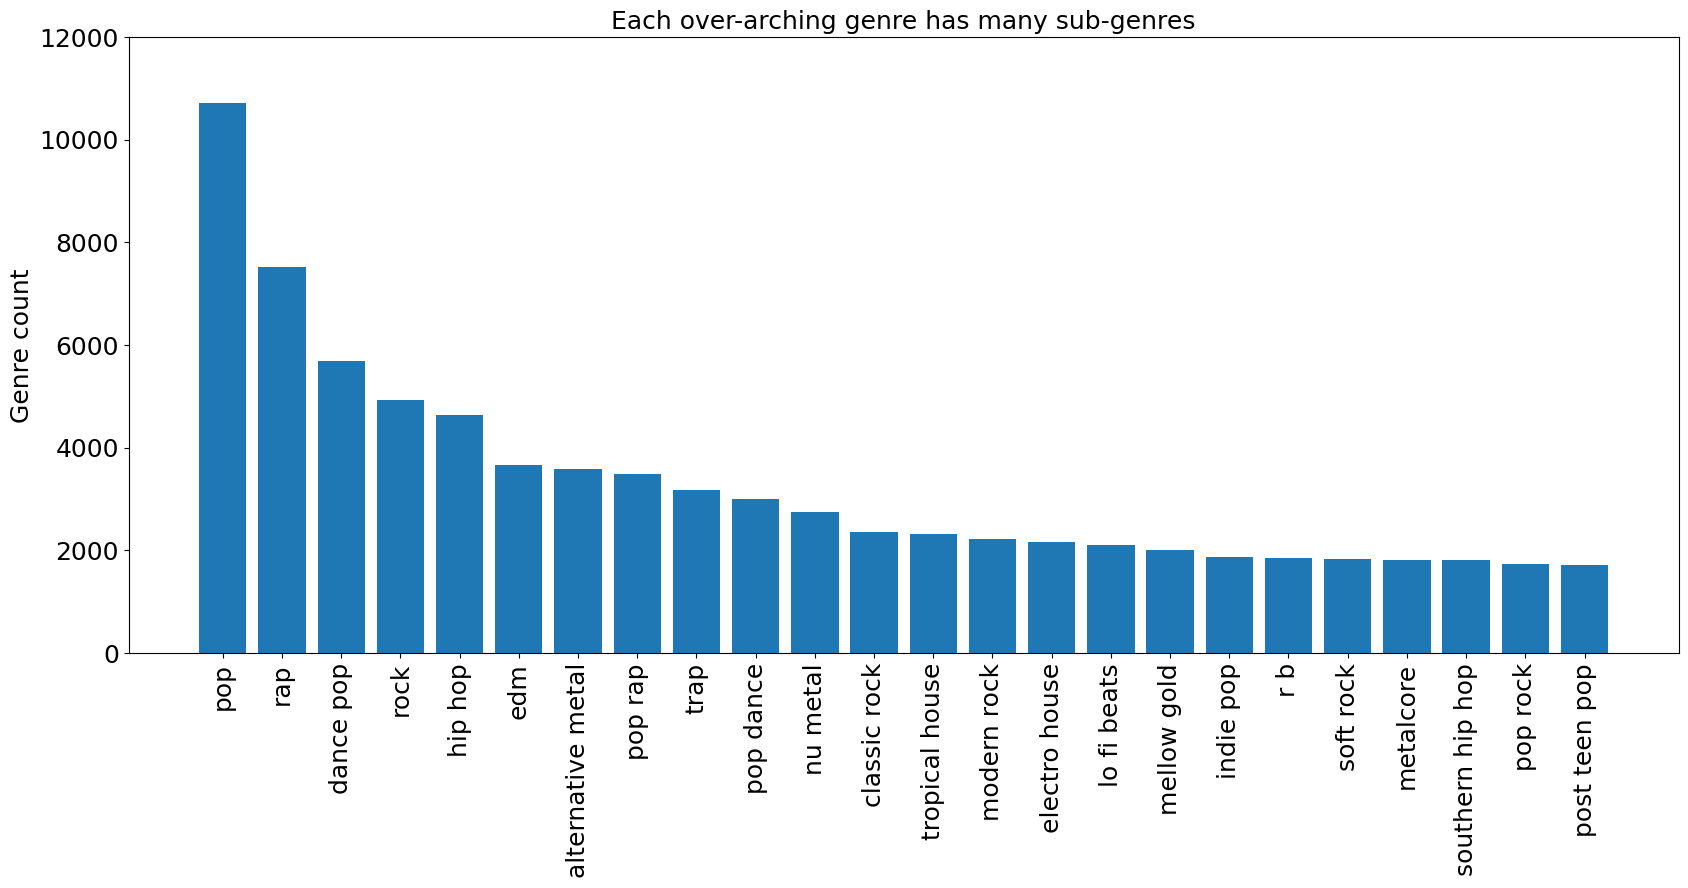

In [298]:
topgenre = genre_name_list[:24]
topcount = genre_count_list[:24]

plt.figure(figsize=(20,8))
plt.bar(topgenre,topcount, align='center')
plt.xticks(topgenre, rotation=90)
plt.title('Each over-arching genre has many sub-genres', fontsize=18)
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.ylabel("Genre count", fontsize=18)
plt.ylim(0, 12000)
plt.show();

We can see that each higher level genre has many sub-genres.  For example 'pop' is accompanied by 'dance pop', 'pop rap', 'pop dance', 'indie pop' and 'pop rock' in the top 25 alone.  Therefore it may be possible to categorise the sub-genres into a larger genre based on key words.

Artists come associated with multiple genres.  Let's find the artist with the the most genres to give us a sense of what we're dealing with.

In [299]:
# find maximum length in genre list
lenmax = 0
indexcounter = -1
for i in new_genre_list:
    indexcounter += 1 
    if len(i) > lenmax:
        lenmax = len(i)
        maxlist = i
        longindex = indexcounter

print(f"Most genres: {lenmax}")
print(f"Genres: {maxlist}")
print(f"Index of artist: {longindex}")

Most genres: 16
Genres: ['album rock', 'art rock', 'beatlesque', 'blues rock', 'bubblegum pop', 'classic rock', 'country rock', 'folk rock', 'jangle pop', 'mellow gold', 'power pop', 'psychedelic rock', 'rock', 'roots rock', 'soft rock', 'symphonic rock']
Index of artist: 17926


In [300]:
df.iloc[17926]

track_id                                       2XKW8CH8nRZH9cF2DNjBHN
track_name                            Day After Day - Remastered 2010
artists                                                     Badfinger
artist_genre        ['album rock', 'art rock', 'beatlesque', 'blue...
popularity                                                         57
danceability                                                    0.399
energy                                                          0.686
key                                                                 5
loudness                                                       -7.112
mode                                                                1
speechiness                                                    0.0311
acousticness                                                    0.109
instrumentalness                                             0.000874
liveness                                                        0.112
valence             

'Badfinger' is the artist with the most genres, a total of 16.  We want to create a counter that runs through each genre in the list per artist, categorises each one into a larger group, and then picks the overall genre for that artist as the overall genre with the highest count.

Let's create a dictionary for each overall genre, which will be added to with each instance that is found in a chosen list of words.

In [301]:
# the list of keywords was initially chosen with a smaller set, and was added to iteratively \
# as more category options were found that end up in 'other'

rocklist = ['rock','alt z', 'punk', 'grunge', 'indie', 'guitar', 'weirdcore']
metallist = ['metal', 'emo', 'hardcore', 'screamo', 'death', 'slayer']
folklist = ['country', 'folk', 'llywood', 'ccm', 'filmi', 'kirtan', 'sad sierreno',
            'mexicana', 'worship', 'afrofuturism', 'americana', 'fingerstyle', 'salsa',
            'musica']
poplist = ['pop', 'songwriter', 'stomp and holler', 'neo mellow', 'sped up', 'a cappella']
electroniclist = ['edm', 'house', 'dance', 'trance', 'tech','bass','electro', 
                  'rave', 'tronica', 'new french touch', 'beats', 'neo mellow',
                  'psych', 'hardstyle', 'rawstyle', 'dnb', 'frenchcore', 'tekk',
                  'phonk', 'breakcore', 'otacore', 'glitch', 'dubstep', 'chillwave']
soullist = ['soul', 'funk', 'r b', 'motown', 'jazz', 'quiet storm', 'reggae', 'disco',
            'r&b', 'adult standards', 'gospel', 'high vibe', 'lo fi']
raplist = ['rap', 'hop', 'trap', 'drill', 'pluggnb', 'gymcore']
instrumentallist = ['classical', 'meditation', 'background', 'orchestral', 'soundtrack', 
                    'ambient', 'sleep', 'instrumental', 'pet calming','vgm', 'pixel', 
                    'piano cover', 'video game music', 'classify', 'pink noise', 
                    'movie tunes', 'piano', 'ukulele', 'orchestra']

#instantiate new list and genre dictionary with counts
grouped_genre_list = []
for artist in new_genre_list:
    genre_counts = {
    'rock': 0,
    'metal': 0,
    'folk': 0,
    'pop': 0,
    'electronic': 0,
    'soul': 0,
    'rap': 0,
    'instrumental': 0,
    'other': 0
    }

# count the genres for each artist and update the dictionary with a counter
    for genre in artist:

        if any(keyword in genre for keyword in rocklist):
            genre_counts['rock'] += 1
        if any(keyword in genre for keyword in metallist):
            genre_counts['metal'] += 1
        if any(keyword in genre for keyword in folklist):
            genre_counts['folk'] += 1
        elif any(keyword in genre for keyword in raplist):
            genre_counts['rap'] += 1
        elif any(keyword in genre for keyword in electroniclist):
            genre_counts['electronic'] += 1
        elif any(keyword in genre for keyword in soullist):
            genre_counts['soul'] += 1
        elif any(keyword in genre for keyword in poplist):
            genre_counts['pop'] += 1
        elif any(keyword in genre for keyword in instrumentallist):
            genre_counts['instrumental'] += 1
        else:
            genre_counts['other'] += 0.1  # give 'unknown' a lower weighting

    # sort the dictionary by values in descending order
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

    # top genre is the first key in the sorted dict, except in the case of a tie,\
    #  in which case the winner is chosen at random from the top scorers
    matching_indices = [0]

    for i in range(1, len(sorted_genres)):
        if sorted_genres[i][1] == sorted_genres[0][1]:
            matching_indices.append(i)
    random.seed(666)
    chosen_index = random.choice(matching_indices)

    max_genre = sorted_genres[chosen_index][0]

    # add genre to the list for that artist
    grouped_genre_list.append(max_genre)

# add as new df column and drop the original
df['grouped_genres'] = grouped_genre_list

print("Sorted genres into wider categories")
print("---")
print_value_counts(df, "grouped_genres")

Sorted genres into wider categories
---
Dataset contains 19464 other songs
Dataset contains 16966 rap songs
Dataset contains 13567 electronic songs
Dataset contains 13179 pop songs
Dataset contains 9381 rock songs
Dataset contains 7749 metal songs
Dataset contains 7235 soul songs
Dataset contains 6422 folk songs
Dataset contains 5834 instrumental songs


The genres in the code above are counted and sorted per artist, and the genre with the highest total counts as the overall genre of that artist.

In the case of a tie, the first genre cannot be picked as this would lead to bias towards whichever genre key was created first in the dictionary.  To avoid this bias, the indices of the top scoring genres are appended to a list, and the winner is chosen at random using random.choice.

Run through the same process as above for all songs in 'other', in order to categorise missed sub-genres by listening to determine which category the most numerous ones belong in.

In [302]:
df_other = df[
    df['grouped_genres'] == 'other'
]

# get genre as a series
genre_other = df_other['artist_genre']

# split into a list using the comma
genre_split_other = genre_other.str.split(", ")

new_genre_list_other = []

for artist in genre_split_other:
    strippedgenre_other = []
    for genre in artist:
        strippedgenre_other.append((re.sub(r'[^\w]', ' ', genre)).strip())
    new_genre_list_other.append(strippedgenre_other)

genre_counts_other = {}  # dictionary to keep track of genre counters

for genres in new_genre_list_other:
    # create a Counter for the current list of genres
    current_genre_count_other = Counter(genres)

    for genre, count in current_genre_count_other.items():
        # update the corresponding counter for the genre in the dictionary
        if genre in genre_counts_other:
            genre_counts_other[genre] += count
        else:
            genre_counts_other[genre] = count

sorted_by_genre_other = sorted(genre_counts_other.items(), key=lambda x:x[1], reverse=True)
sorted_by_genre_other.pop(0)
sorted_by_genre_other

[('slowcore', 41),
 ('soca', 39),
 ('yaoi', 38),
 ('opm', 38),
 ('slowed and reverb', 38),
 ('bossbeat', 35),
 ('big room', 34),
 ('red dirt', 33),
 ('comic', 30),
 ('acoustic chill', 29),
 ('vocaloid', 27),
 ('show tunes', 27),
 ('epicore', 27),
 ('acoustic cover', 26),
 ('dreamo', 26),
 ('easy listening', 25),
 ('chillstep', 25),
 ('sigilkore', 25),
 ('anime score', 25),
 ('chill out', 25),
 ('men chika', 24),
 ('children s music', 24),
 ('binaural', 24),
 ('melbourne bounce international', 23),
 ('partyschlager', 23),
 ('lds', 23),
 ('zxc', 22),
 ('middle earth', 22),
 ('vbs', 21),
 ('rebel blues', 20),
 ('chanson', 18),
 ('hands up', 18),
 ('wave', 17),
 ('shamanic', 17),
 ('american shoegaze', 17),
 ('white noise', 16),
 ('broadway', 16),
 ('cover acustico', 16),
 ('escape room', 16),
 ('preschool children s music', 16),
 ('relaxative', 16),
 ('bachata', 16),
 ('modern big band', 15),
 ('hardwave', 15),
 ('russian drain', 15),
 ('vapor twitch', 15),
 ('cartoon', 15),
 ('rain', 14)

In [303]:
len(sorted_by_genre_other)

502

We have added key words from sub-genres iteratively until the count of the top uncategorised sub-genre is below 50.  There are still over 500 uncategorised genres, and in an ideal scenario we would have time to label more sub-genres but these are not having a large influence on the dataset as a whole.

This step of labelling genres into wider categories is highly subjective and prone to bias.  For example if the labeller is more familiar with certain genres they may be more or less likely to include it in a certain category, or to create a wider genre in the first place.

### Analyse and pre-process `Genre`

Genre is a fundamental way that music is categorised and classified based on shared musical characteristics and cultural contexts.  Each genre has its own unique set of conventions in terms of rhythms, instruments and vocal styles; all of which can influence the emotional impact of the music.

For example, electronic tends to be made to invoke feelings of happiness with upbeat rhythms to encourage movement, whereas metal is built on the basis of anger and frustration.

Therefore we would expect genre to be a good indicator of mood, with metal expected to have a higher proportion of sad and energetic songs, and electronic to have a higher proportion of happy and energetic songs.

Let's plot the percentage of each mood for each genre.

In [304]:
# count number of each mood in each genre
genre_groups = df.groupby(['grouped_genres', 'playlist_mood'])['playlist_mood'].count()

#count total tracks for each genre
genre_totals = df.groupby(['grouped_genres'])['playlist_mood'].count()

# calculate percentage for each genre
genre_groups_pct = genre_groups.div(genre_totals, level='grouped_genres') * 100

# get into form for plotting
genre_groups_pct_unstack = genre_groups_pct.unstack().reset_index()
genre_groups_df = genre_groups_pct_unstack.set_index('grouped_genres')

genre_groups_df


playlist_mood,chill,energetic,happy,sad
grouped_genres,,,,
electronic,17.601533,29.313776,37.915530,15.169160
folk,21.192775,19.713485,25.677359,33.416381
instrumental,42.115187,11.244429,26.208433,20.431951
metal,1.367918,34.804491,2.993935,60.833656
other,33.050760,18.166872,26.715988,22.066379
pop,21.708779,16.571819,27.581759,34.137643
rap,15.660733,31.398090,30.649534,22.291642
rock,24.784138,23.131862,24.485663,27.598337
soul,37.567381,17.581202,28.970283,15.881133


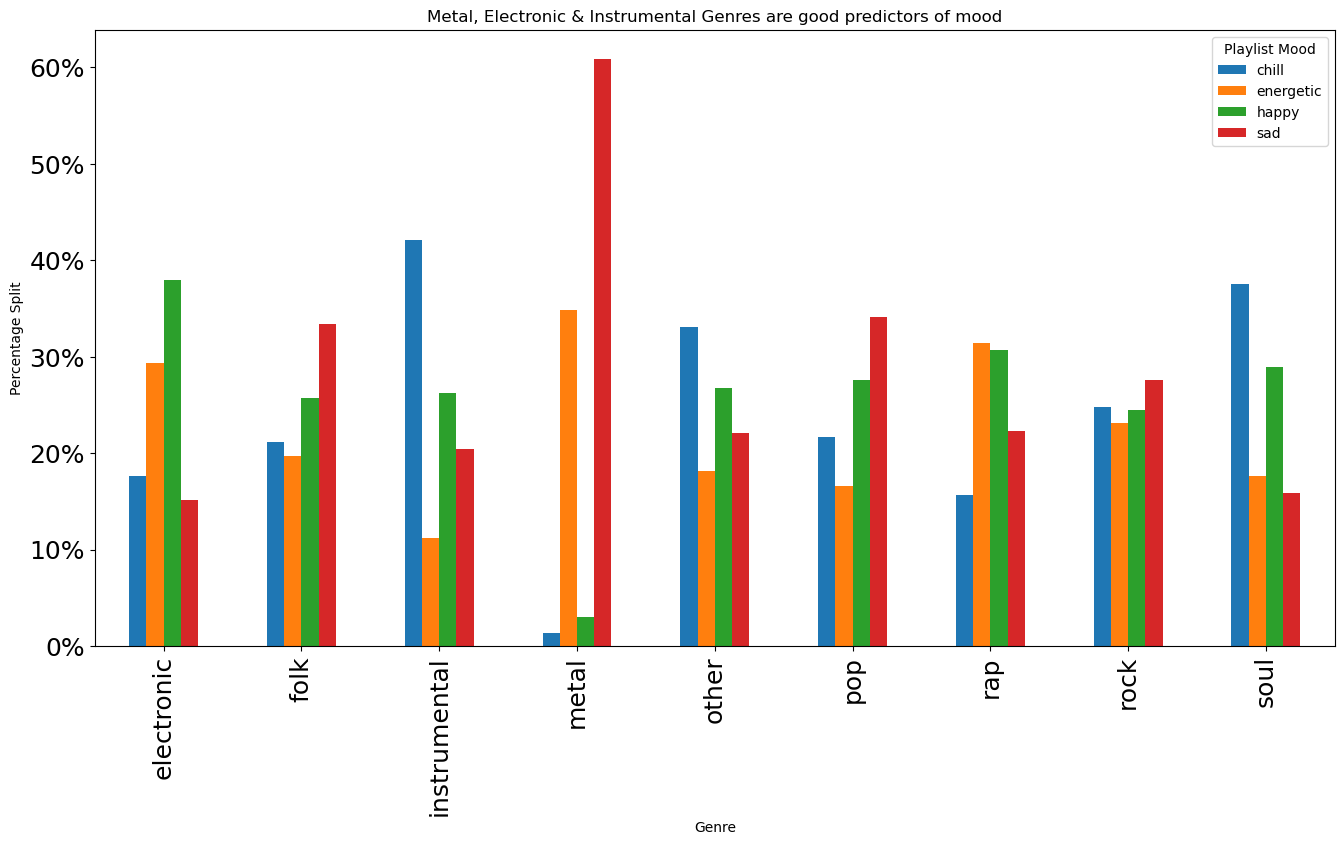

In [305]:
# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(16, 8))
genre_groups_df.plot(kind='bar', ax=ax)

# Set chart title and axis labels
ax.set_title('Metal, Electronic & Instrumental Genres are good predictors of mood')
ax.set_xlabel('Genre')
ax.set_ylabel('Percentage Split')

# Set legend location and title
ax.legend(loc='best', title='Playlist Mood')

# Set y-axis to display percentages
ax.set_yticklabels(['{:,.0f}%'.format(x) for x in ax.get_yticks()])

# Show chart
plt.show()

The bar chart shows that we can expect some genres to be good predictors of mood:

- Metal is dominated by sad and energetic songs
- Instrumental is dominated by chilled songs
- Electronic is mostly happy and energetic songs
- Soul is mostly chilled and happy songs
- Rap is mostly energetic and happy
- Folk is mostly sad
- Rock has a fairly even spread so is unlikely to be a good predictor

We want to convert genre into individual binary columns (i.e. dummies) for the modelling.

Convert and drop the original genre columns

In [306]:
# convert genres into dummies and drop original
genre_dummies = pd.get_dummies(df['grouped_genres'], prefix="genre")
df = pd.concat([df, genre_dummies], axis=1)

df.drop(columns='grouped_genres', inplace=True)
df.drop(columns="artist_genre", inplace=True)

#### Analyse and pre-process `duration_ms`

The histograms in the intial analysis showed the duration to have outliers that made the pattern hard to determine.  Let's plot the duration but limit the x-range.

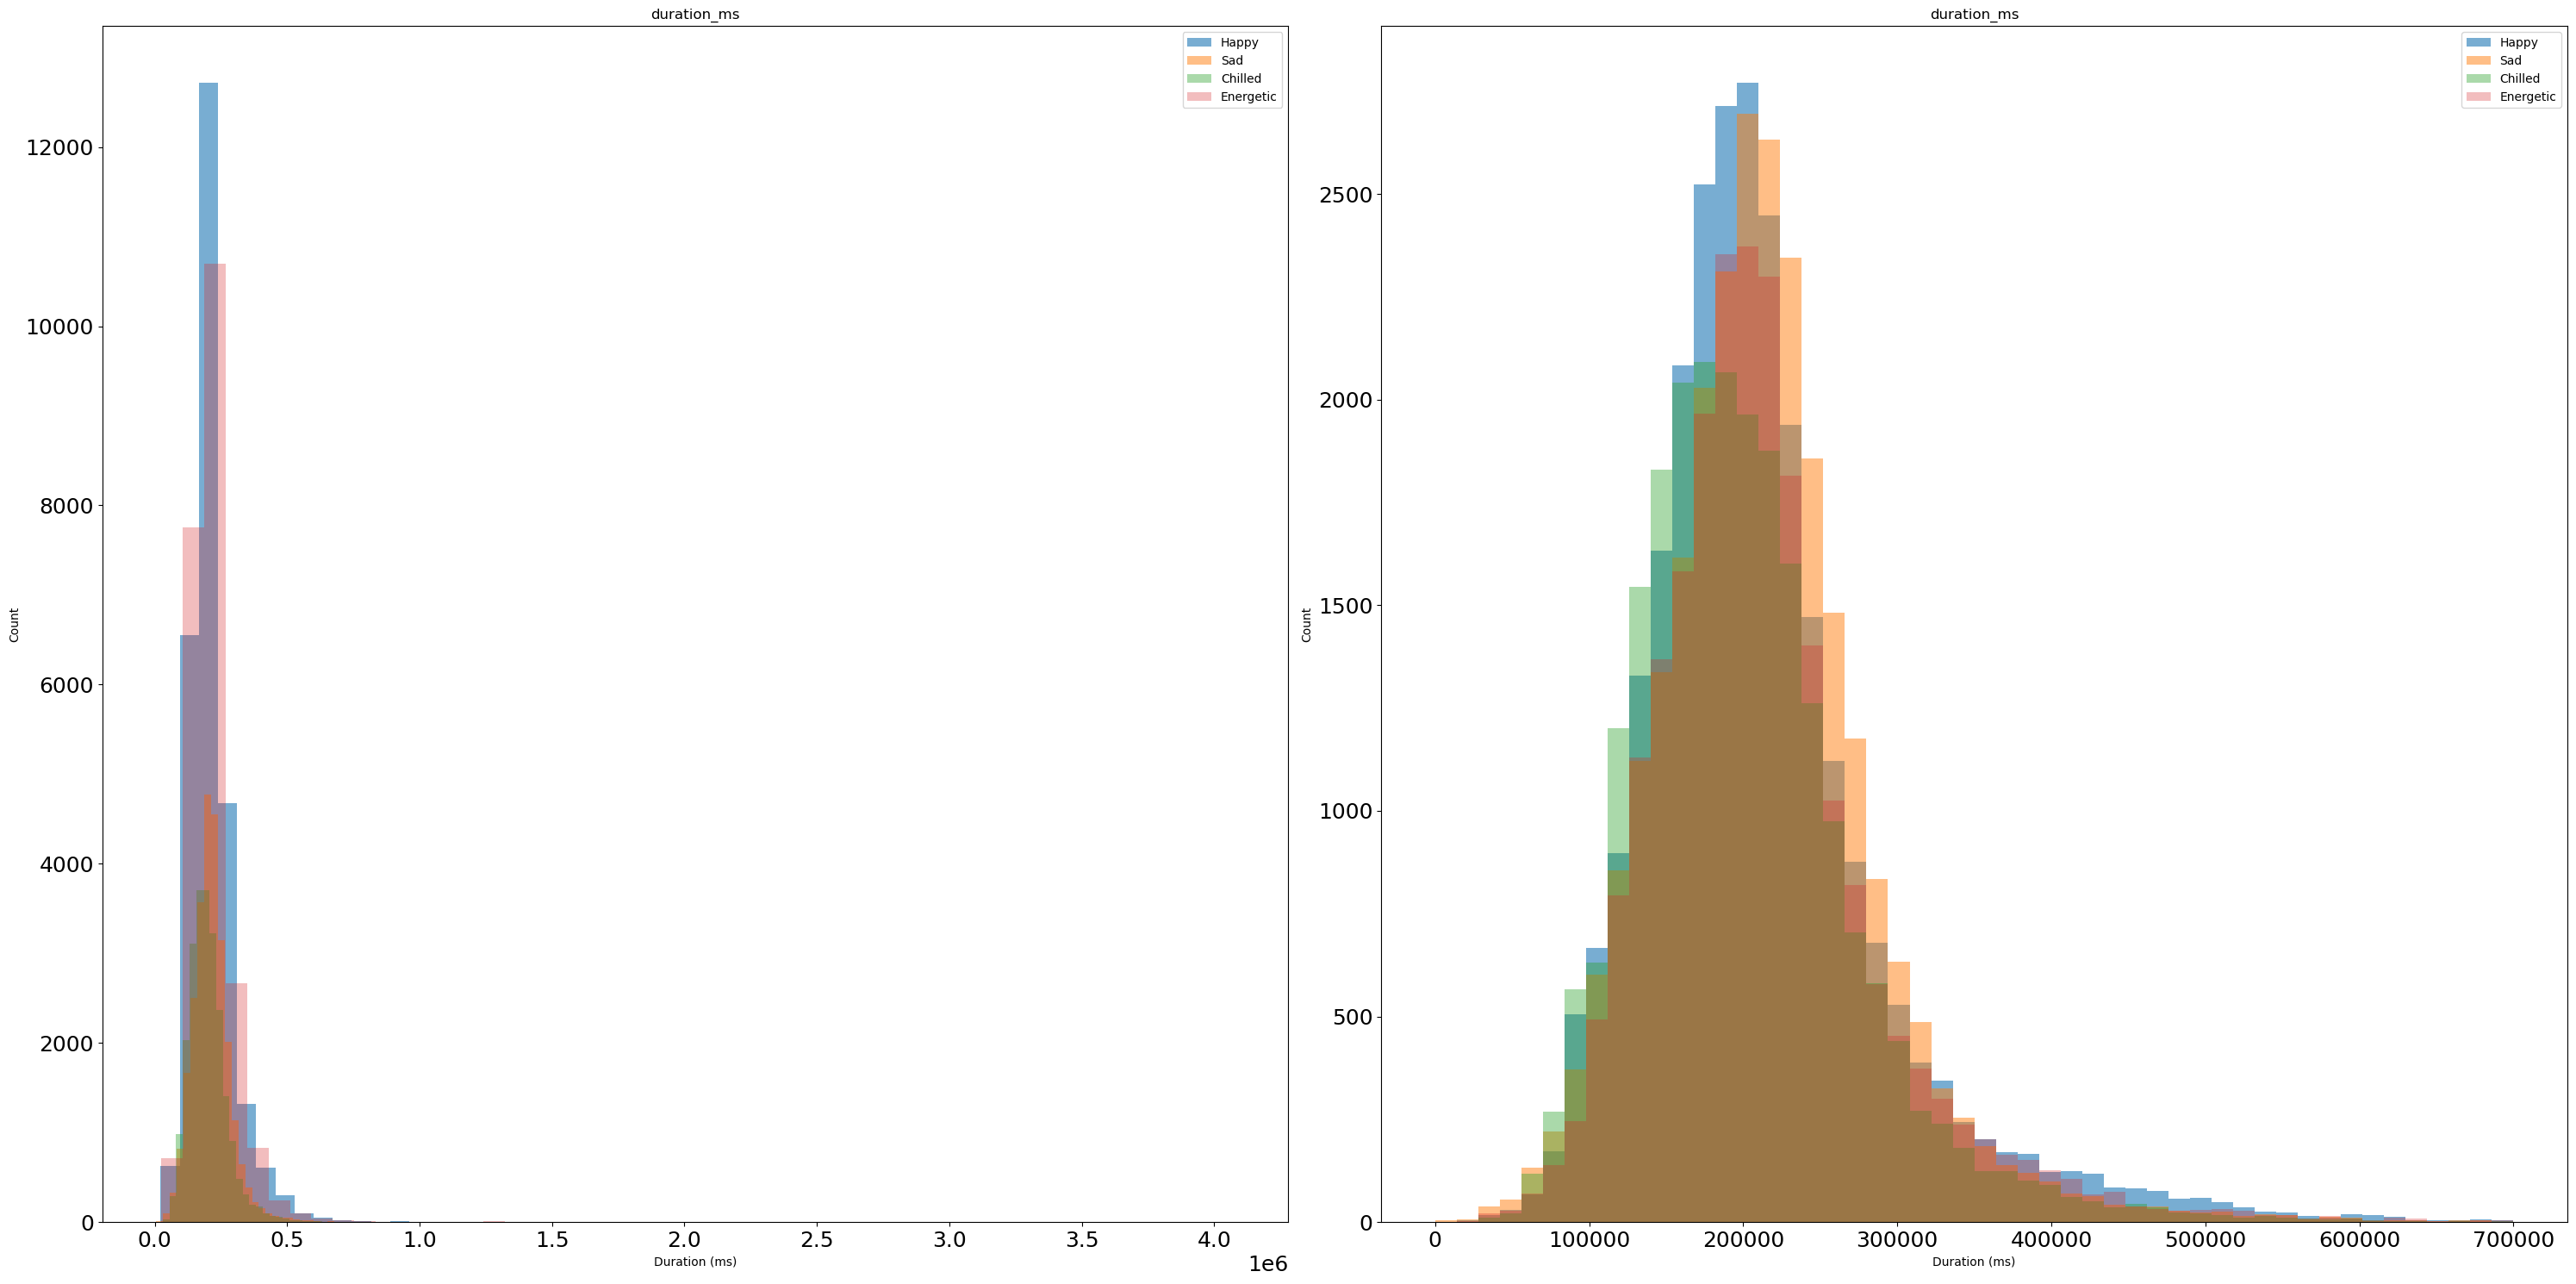

In [307]:
plt.subplots(1, 2, figsize=(30, 15))

plt.subplot(1, 2, 1)
col = 'duration_ms'
plt.hist(df_happynum[col], bins=50, alpha=0.6, label='Happy', edgecolor='None')
plt.hist(df_sadnum[col], bins=50, alpha=0.5, label='Sad',edgecolor='None')
plt.hist(df_chillnum[col], bins=50, alpha=0.4, label='Chilled', edgecolor='None')
plt.hist(df_energynum[col], bins=50, alpha=0.3, label='Energetic', edgecolor='None')
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.xlabel("Duration (ms)")
plt.ylabel("Count")
plt.legend(loc='upper right')
plt.title(col)


plt.subplot(1, 2, 2)
col = 'duration_ms'
plt.hist(df_happynum[col], bins=50, alpha=0.6, label='Happy', range=[0, 7e5], edgecolor='None')
plt.hist(df_sadnum[col], bins=50, alpha=0.5, label='Sad', range=[0, 7e5], edgecolor='None')
plt.hist(df_chillnum[col], bins=50, alpha=0.4, label='Chilled', range=[0, 7e5], edgecolor='None')
plt.hist(df_energynum[col], bins=50, alpha=0.3, label='Energetic', range=[0, 7e5], edgecolor='None')
plt.xlabel("Duration (ms)")
plt.ylabel("Count")
plt.legend(loc='upper right')
plt.title(col)
    
plt.tight_layout()
plt.show()

From the range-limited histogram we can see a small skew in peak of Sad songs to longer durations, and the peak of Chilled songs to be shorter durations.  These differences could be helpful in predicting the mood.

Check the statistical ranges of `duration_ms`

In [308]:
df['duration_ms'].describe()

count    9.979700e+04
mean     2.105705e+05
std      8.115176e+04
min      4.933000e+03
25%      1.625330e+05
50%      2.016270e+05
75%      2.424130e+05
max      4.076920e+06
Name: duration_ms, dtype: float64

- Mean is 2.1e5 ms which equates to 210 seconds
- Upper quartile is 2.4e5 ms which equates to 240 seconds
- Maximum is 4.1e6 ms which equates to 1 hour, 8 minutes

We should consider whether it is worth limiting the range of duration, so that above a certain length a song is limited to the maximum duration.  This is a sensible approach as outliers could have an overly strong influence on the estimates of our modelling, and if a song is longer than, for example, 15 minutes, then it is still a 'long' song whether the model sees it as 15 minutes or an hour.

Let's look at limiting the duration to the 99.87% percentile value, based on what is considered outliers for a normal distribution

In [309]:
# Sort the values and reset the index
sorted_duration = (df['duration_ms'].sort_values()).reset_index()

In [310]:
# use iloc to find the duration value of the 99.87th percentile
sorted_duration.iloc[round((df.shape[0]*0.9987))]

index           21361
duration_ms    707600
Name: 99667, dtype: int64

In [311]:
707600/ 1000 / 60

11.793333333333333

The duration at the 99.87th perentile is 707600ms which equates to just under 12 minutes.  This value matches where we manually limited our histogram by eye, and taking a common sense approach, 12 minutes is about as long as any regular song gets.

Limit outliers to the maximum value of 707600ms (Winsorize).

In [312]:
df['duration_ms'] = df['duration_ms'].apply(lambda x: min(x, 707600))

Re-plot the histogram for all moods to sanity check.

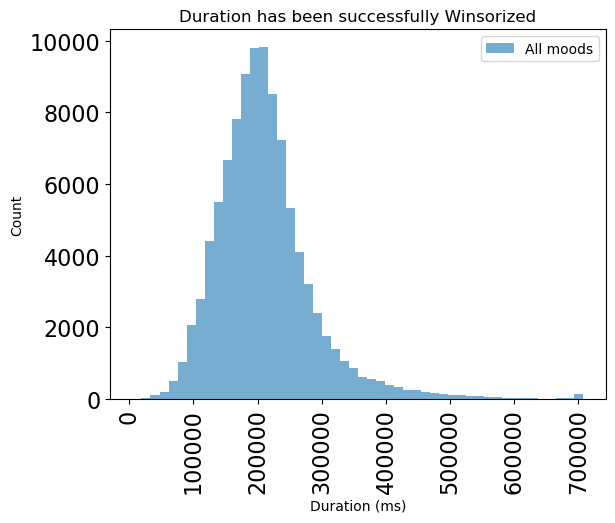

In [313]:
col = 'duration_ms'
plt.hist(df[col], bins=50, alpha=0.6, label='All moods')
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.xlabel("Duration (ms)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title("Duration has been successfully Winsorized");

### Analyse and pre-process `time_signature`

Time-signature indicates the number of beats in each measure, and can have an effect on the feeling and mood of music.  For example 4/4, or 'common time' has a steady driving rhythm, and can evoke feelings of excitement or energy, whereas 3/4 can give music a more relaxed or introspective feel.

We would therefore expect a discrepancy between the relevant numbers of tracks of each mood in each time signature, for example we would expect a 4/4 time signature to have fewer Chilled songs and more Happy songs.

Let's plot the relative time-signatures per mood

In [314]:
# group by time signature and mood
time_sig = df.groupby(['time_signature','playlist_mood'])['playlist_mood'].count()

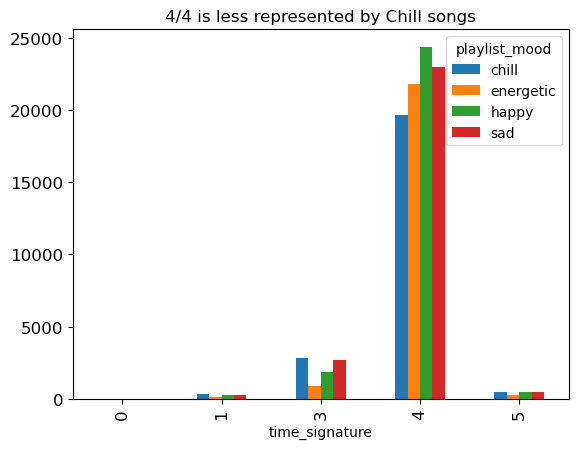

In [315]:
#unstack and plot
time_sig_unst = time_sig.unstack()
# visualise the time signatures
time_sig_unst.plot.bar(title = "4/4 is less represented by Chill songs");

The bar chart backs up our initial theory that Chilled songs are less likely to be in 4/4, and Happy songs more likely.  These charts are in gross numbers at the moment, and although the relative numbers are fairly similar, let's check percentages for completeness.

In [316]:
# count number of occurences of each mood in each time sig
time_sig_grps =  df.groupby(['time_signature', 'playlist_mood'])['playlist_mood'].count()
time_sig_grps

time_signature  playlist_mood
0               chill                6
                energetic            2
                happy                1
                sad                 11
1               chill              353
                energetic          104
                happy              257
                sad                276
3               chill             2836
                energetic          905
                happy             1896
                sad               2700
4               chill            19611
                energetic        21809
                happy            24348
                sad              22940
5               chill              500
                energetic          265
                happy              480
                sad                497
Name: playlist_mood, dtype: int64

In [317]:
# count total number of each time signature
time_sig_counts = df.groupby(['time_signature'])['playlist_mood'].count()
time_sig_counts

time_signature
0       20
1      990
3     8337
4    88708
5     1742
Name: playlist_mood, dtype: int64

In [318]:
# divide groups by total counts to get percentage and reset index for plotting
time_sig_pct = time_sig_grps.div(time_sig_counts, level='time_signature') * 100
time_sig_pct_reset = time_sig_pct.unstack().reset_index()

time_sig_pct_reset

playlist_mood,time_signature,chill,energetic,happy,sad
0,0,30.000000,10.000000,5.000000,55.000000
1,1,35.656566,10.505051,25.959596,27.878788
2,3,34.017033,10.855224,22.741994,32.385750
3,4,22.107363,24.585156,27.447355,25.860125
4,5,28.702641,15.212400,27.554535,28.530425


Plot the time signatures by percentage make-up of each mood.

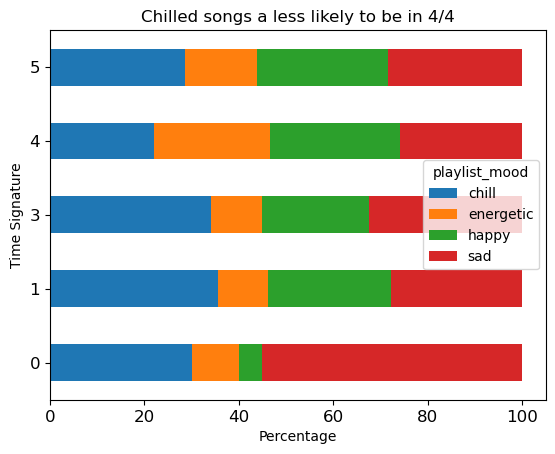

In [319]:
time_sig_pct_reset.plot(
    x = 'time_signature',
    kind = 'barh',
    stacked = True,
    title = 'Chilled songs a less likely to be in 4/4',
    xlabel = 'Percentage',
    ylabel = 'Time Signature',
    );

We can see from the stacked horizontal bar chart and from the percentages table above, that Chilled songs have the lowest proportion of songs in 4/4, and Happy songs have the highest.  Chilled songs are consistenly more present other time signatures than other moods.

The low total number of songs present in time-signatures other than 4/4, combined with what we know about time-signatures and the feelings they give to music, mskes it sensible to split the time-signature into "4/4" or "non-4/4".

The presence of a time-signature of "0 or 1" seems questionable, and doing direct QC by listening to some examples of these songs in Spotify, the 0 songs appear to be in other time-signatures such as 6/8 that the Spotify audio-features detection can't classify, and the 1 songs are slow songs with a mix of time signatures.  We will assume that there is something inherently unusual about these time-signatures so that they aren't classified as 4/4  Therefore let's group the "0 and 1" tracks into "non-4/4".

Examples of songs with "0" time-signature

In [320]:
df[
    df['time_signature'] == 0
].sample(5, random_state=33)

,track_id,track_name,artists,popularity,danceability,energy,key,loudness,mode,speechiness,...,playlist_mood,genre_electronic,genre_folk,genre_instrumental,genre_metal,genre_other,genre_pop,genre_rap,genre_rock,genre_soul
84150,4PGPP56pVjy9fqmTyT3LCG,Ringwil,Little Symphony,38,0.0,0.3990,2,-24.193,1,0.0,...,chill,0,0,1,0,0,0,0,0,0
50655,2Ww0Z9GZY8JeA45v0Bks8C,7 O'Clock News / Silent Night,"Phoebe Bridgers, Fiona Apple, Matt Berninger",0,0.0,0.4800,6,-10.535,1,0.0,...,sad,0,0,0,0,0,0,0,1,0
72308,571RkdjnaMLRRLZAKLaGV2,B-Messenger -strings quartet-,Nobuaki Nobusawa,52,0.0,0.1280,4,-18.253,0,0.0,...,sad,0,0,0,0,1,0,0,0,0
90402,3sAYxq1986j3ydqLv6jwUJ,"Serenade for Strings in E Major, Op. 22, B. 52...","Antonín Dvořák, Prague Chamber Orchestra, Petr...",63,0.0,0.0842,9,-19.397,1,0.0,...,energetic,0,0,1,0,0,0,0,0,0
39808,6sI9Zd5P0aL0dENCcmWqcu,Neonatalimpalionecrophiliation,Infant Annihilator,0,0.0,0.5660,4,-3.294,1,0.0,...,sad,0,0,0,1,0,0,0,0,0


In [321]:
df[
    df['time_signature'] == 1
].sample(5, random_state=5)

,track_id,track_name,artists,popularity,danceability,energy,key,loudness,mode,speechiness,...,playlist_mood,genre_electronic,genre_folk,genre_instrumental,genre_metal,genre_other,genre_pop,genre_rap,genre_rock,genre_soul
44809,2NWRR4Hy49RvY57VRRlrBm,when the dust settles,chey guy,11,0.543,0.45000,7,-10.023,1,0.1120,...,sad,0,0,0,0,1,0,0,0,0
45974,7bTOYXenaNkCLQ6hOYWGNw,Rianbavy,Little Symphony,33,0.164,0.00798,0,-25.198,1,0.0495,...,chill,0,0,1,0,0,0,0,0,0
35412,54VRxTPDkLeKnuatjUuYIh,Mystic River,Enzo,0,0.169,0.01420,7,-27.360,0,0.0342,...,energetic,1,0,0,0,0,0,0,0,0
53486,6rvmhiAd5jtT5CzLIcnj4p,Nouvelles Tentatives,Zander Shaelyn,68,0.405,0.01870,10,-29.086,1,0.0372,...,happy,0,0,0,0,1,0,0,0,0
87716,0KiUE3zdD3M8IRLcNDbjfv,"Something Good - From ""The Sound Of Music""","Richard Rodgers, Van-Anh Nguyen",39,0.467,0.00556,1,-27.983,1,0.0502,...,chill,0,0,0,0,1,0,0,0,0


4/4 is also known as 'common_time', so let's create a binary column with this name that indicates whether a song is in 4/4 or not.

In [322]:
# map to common or not common time

df["common_time"] = df["time_signature"].map(
    {
        4: 1,
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        5: 0,
        
    }
)
df["common_time"].value_counts()

1    88708
0    11089
Name: common_time, dtype: int64

Let's plot the percentages of common time of each mood

In [323]:
# group by mood and commont time and unstack
common_time = df.groupby(['playlist_mood', 'common_time'])['common_time'].count()
common_time_unst = common_time.unstack()
common_time_unst

common_time,0,1
playlist_mood,,
chill,3695,19611
energetic,1276,21809
happy,2634,24348
sad,3484,22940


In [324]:
# create total and percentage of each
total = common_time_unst.sum(axis=1)
common_time_pct = (common_time_unst.values[:,1] / total) * 100
uncommon_time_pct = 100-common_time_pct

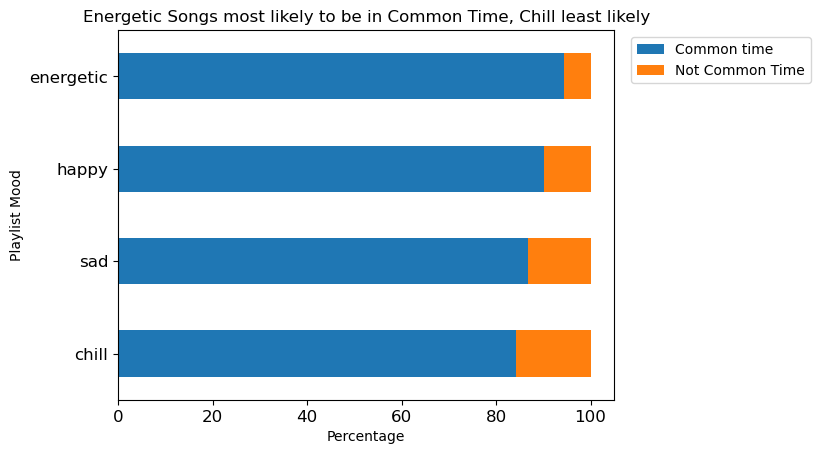

In [325]:
# create a DataFrame with both Series
ct_df = pd.DataFrame({'common_time': common_time_pct, 'not_common_time': uncommon_time_pct})
ct_df = ct_df.sort_values(by='common_time', ascending=True)

# create stacked bar chart
ax = ct_df.plot(kind='barh', stacked=True)
ax.set_xlabel('Percentage')
ax.set_ylabel('Playlist Mood')
ax.legend(['Common time', 'Not Common Time'], bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_title('Energetic Songs most likely to be in Common Time, Chill least likely')
plt.show()

The stacked bar chart shows that Energetic songs are most likely to be in common time, with Chilled songs the least likely.

This matches our expectation that the time-signature is heavily related to the feeling of a song, with unconventional time-signatures giving a more relaxed feeling, with songs in 4/4 having more drive and purpose.

The differential between energetic and chilled songs in this feature should make it a useful indicator for predicting an energetic song.  The smaller difference between Happy and Sad songs means it may be less useful for predicting this relationship.

Drop the original `time_signature` column|

In [326]:
df.drop(columns='time_signature', inplace=True)

### Analyse `mode`

Mode is an important element that can contribute to the emotional feeling of a song.  The major mode tends to evoke feelings of happinness and brightness, whereas the minor mode evokes more sadness and darkness.

We would expect this to be a good indicator of a Happy vs a Sad song, with Happy expected to have more major mode songs.

In categorising Energetic vs Chilled we would expect there to be less difference in the mode, with low energy songs having the potential for happiness and sadness, i.e. zen songs vs melancholy songs.  The same is likely to be true of high energy songs, with euphoic songs expected to be in the major mode, and angry/aggressive songs expected to be in the minor mode.

Let's plot the mode for each mood as a percentage of the total.

In [327]:
# group by mood and mode, calculate percentage, and unstack for plotting
mode_pct = (df.groupby(['playlist_mood', 'mode',])['mode',].count()  /  df.groupby(['playlist_mood'])['mode',].count()  * 100).unstack().reset_index()

In [328]:
mode_pct.set_index('playlist_mood')

mode           
mode                   0          1
playlist_mood                      
chill          34.574788  65.425212
energetic      40.485164  59.514836
happy          38.240308  61.759692
sad            37.643809  62.356191

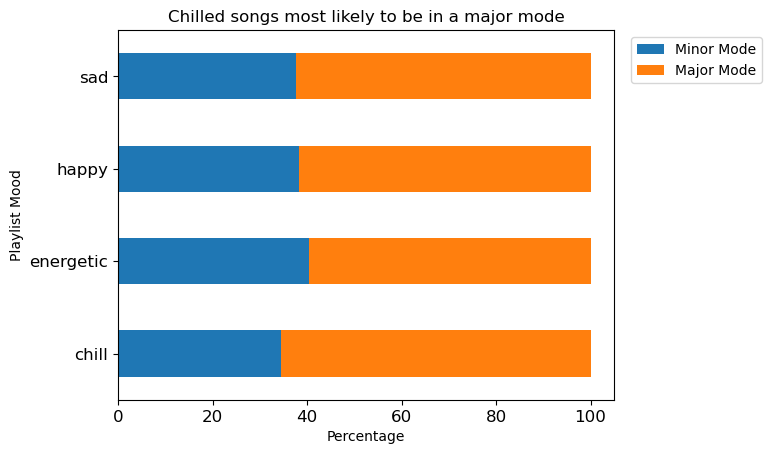

In [329]:
# create stacked bar chart
ax = mode_pct.set_index('playlist_mood').plot(kind='barh', stacked=True)
ax.set_xlabel('Percentage')
ax.set_ylabel('Playlist Mood')
ax.legend(['Minor Mode', 'Major Mode'], bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_title('Chilled songs most likely to be in a major mode')
plt.show()

The bar chart shows that our expectations were not met, and that happy and sad songs are almost equally likely to be in a major mode, with chilled songs the most likely. Based on what we know about mode and its effect on the feeling in music, this is extremely surprising.

Further research was conducted by listening to Happy songs supposedly in a minor mode, and additional web research, which cast doubt on Spotify's ability to accurately predict the mode of a song from its audio file.

"..it seems that Spotify’s use of Echo Nest can, with relative accuracy, interpret the audio signal of the file, but then inaccurately casts an interpretation of Key and subsequently, Harmonic Progression."

https://medium.com/@FinchMF/praise-questions-and-critique-spotify-api-38e984a4174b

If the mode feature is indeed accurate, then it will not be a good predictor of a happy song, and the small difference in percentage between energetic and chilled suggests it may not be a great predictor of energetic songs either.

### Analyse and pre-process `key`

The key is another factor that can affect the feeling of a song.  The key is determined by the pitch of the root note and the relationship between the notes in the scale can create different moods and emotions, especially when coupled with the associated mode.  For example, C major is associated with innocent happiness, and Db major is associated with depressive grief.

Ideally we would combine the key with the mode to make predictions about which keys we would expect to have higher proportions for each mood, however due to the uncertainty in the mode accuracy (and also the key), we will forgo this level of detail and skip straight to comparing the quantities in each mood.


https://ledgernote.com/blog/interesting/musical-key-characteristics-emotions/



Let's plot the percentage make-up of each key by playlist mood.  I.e. if all moods were equally distributed for each key then we would expect an even 25% split.

In [330]:
# count each key
moodkey = df.groupby(['key', 'playlist_mood'])['key'].count()

# convert to percentage (by mood)
moodkey_pct = df.groupby(['key', 'playlist_mood'])['key'].count() / df.groupby('playlist_mood')['playlist_mood'].count() * 100

In [331]:
moodkey_pct_unst = moodkey_pct.unstack()
moodkey_unst = moodkey.unstack()

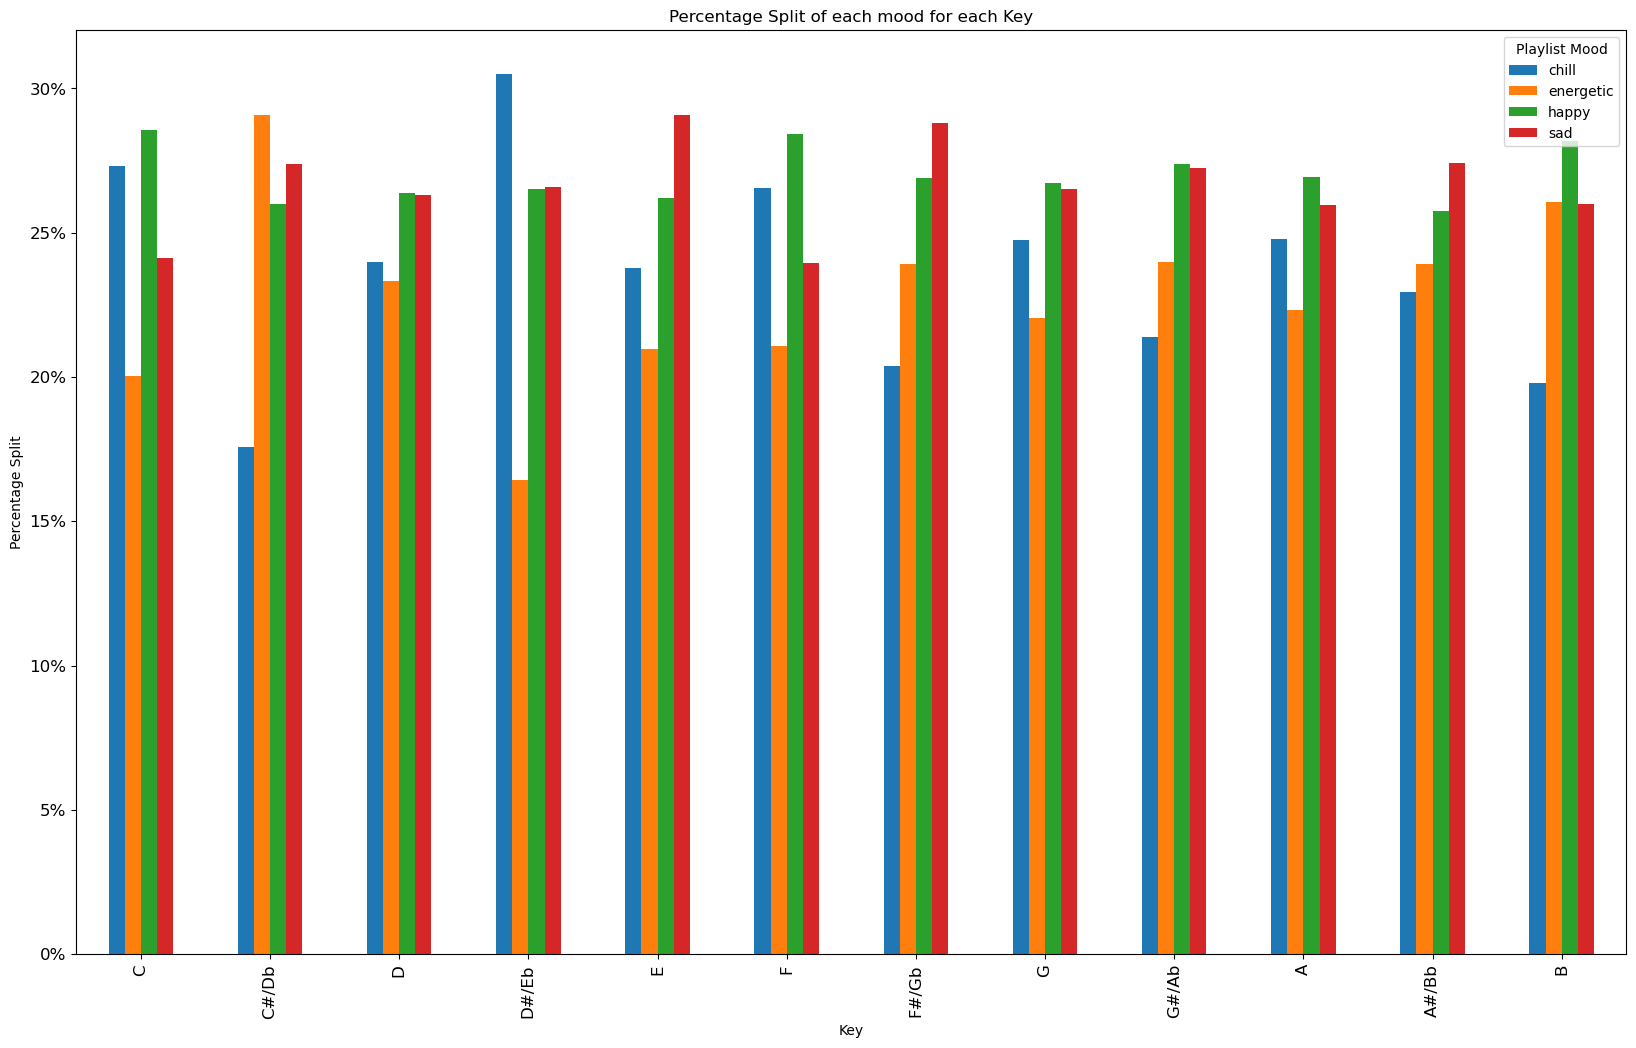

In [332]:
# Calculate percentage split of each mood within each key (i.e. if all were equally distributed we would expect 25% for each mood for each key)
moodkey_sum = df.groupby(['key'])['key'].count()
key_permood_pct = moodkey_unst.div(moodkey_sum, axis=0) * 100

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(20, 12))
key_permood_pct.plot(kind='bar', ax=ax)

# Set chart title and axis labels
ax.set_title('Percentage Split of each mood for each Key')
ax.set_xlabel('Key')
ax.set_ylabel('Percentage Split')

# Set legend location and title
ax.legend(loc='best', title='Playlist Mood')

# Set y-axis to display percentages
ax.set_yticklabels(['{:,.0f}%'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B'])

# Show chart
plt.show()

We can see from the bar chart that there are noticeable lower percentages of energetic songs in D#/Eb and C (and conversely higher proportion of chill).  Therefore a song being in this key would be a good predictor of being a chilled song.

The converse is true for C#/Db and B with higher proportion for Energetic than chilled.

The difference in propotions of mood is less between happy/sad songs, with the biggest discrepancy coming from C and F.

This plot can be a little hard to visualise, so let's plot the same but as a ratio heatmap.

In [333]:
key_permood_pct

playlist_mood,chill,energetic,happy,sad
key,,,,
0,27.300830,20.031797,28.546193,24.121180
1,17.563040,29.068947,26.000705,27.367307
2,23.991077,23.321841,26.384101,26.302981
3,30.493792,16.430840,26.508807,26.566561
4,23.782954,20.951318,26.196122,29.069605
5,26.546547,21.081081,28.420420,23.951952
6,20.387949,23.909754,26.895034,28.807264
7,24.733475,22.058538,26.710603,26.497383
8,21.381990,23.976689,27.390037,27.251283


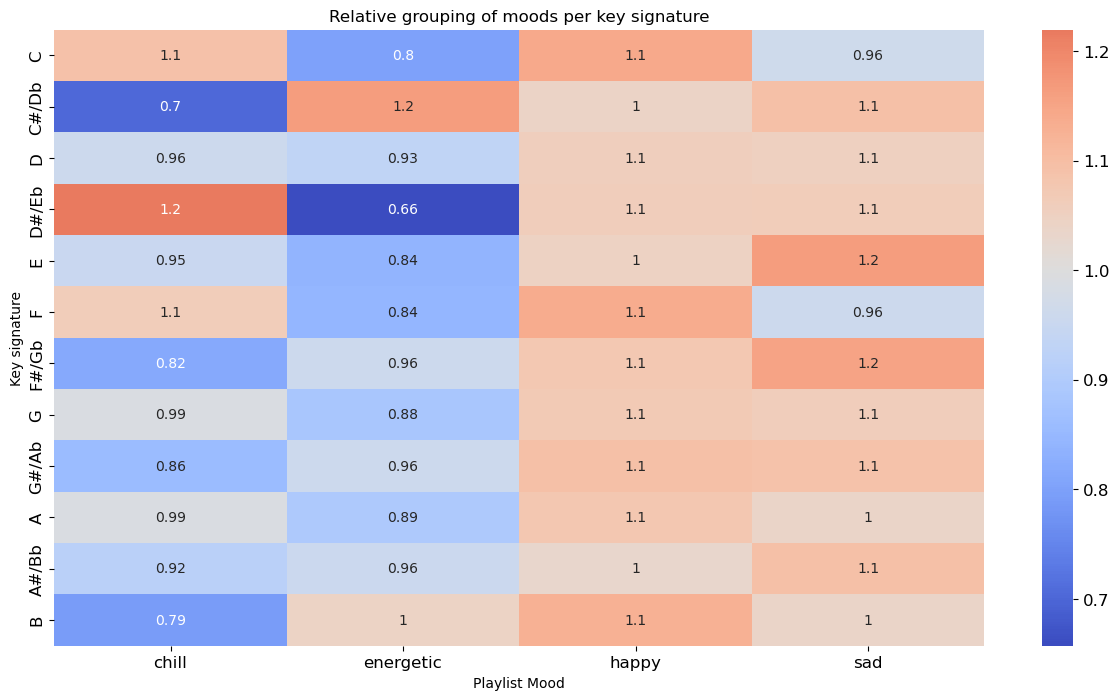

In [334]:
moodkeyratio = key_permood_pct / 25

plt.figure(figsize=(15, 8))
sns.heatmap(moodkeyratio, annot=True, cmap='coolwarm', center=1, yticklabels=(['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']))
plt.xlabel("Playlist Mood")
plt.ylabel("Key signature")
plt.title(label="Relative grouping of moods per key signature")
plt.show()

The same trends come through on the heatmap, and it is a little easier to get a quick impression from.  The range of colours is more stark on the energetic and chilled moods, which means we can expect the key to be a more useful predictor for Energetic/Chilled than Happy/Sad.

Convert key to dummies and drop the original.  Map it to more interpretable names before converting to dummies.

In [335]:
# convert key column to actual key so it is more interpretable before creating dummies
df["key_sig"] = df["key"].map(
    {
        0: 'C',
        1: 'Db',
        2: 'D',
        3: 'Eb',
        4: 'E',
        5: 'F', 
        6: 'Gb',
        7: 'G',
        8: 'Ab',
        9: 'A',
        10: 'Bb',
        11: 'B'
        
       
    }
)
# convert key into dummies and drop originals
key_dummies = pd.get_dummies(df['key_sig'], prefix="key")
df = pd.concat([df, key_dummies], axis=1)

df.drop(columns=['key', 'key_sig'], inplace=True)

### Analyse and pre-process `Explicit`

Explicit lyrics are a factor that can influence the emotional impact of a song.  Lyrics that contain explicit language may be more likely to evoke feelings of passion or aggression, whereas lyrics that are more subtle and gentle may be more likely to evoke feelings of intimacy or relaxation.

Therefore we would expect sad and energetic songs to have higher proportions of explicit lyrics than happy or chilled.

Let's plot the percentage of explicit lyrics for each mood.

In [336]:
# set the explicit tag true or false to a 1 or 0
df["explicit"] = df["explicit"].astype(int)

# count the instances of explicit songs for each mood
explicit_count = df.groupby(["playlist_mood", "explicit"])["explicit"].count()

# calculate the total songs for each mood
mood_sum = df.groupby("playlist_mood").count()['explicit']

# calculate the percentage of explicit out of the total
explicit_pct = explicit_count.div(mood_sum, level='playlist_mood') * 100

# unstack and convert to a dataframe for plotting
explicit_pct_unst = explicit_pct.unstack().reset_index()
explicit_df = explicit_pct_unst.set_index('playlist_mood')
explicit_df

explicit,0,1
playlist_mood,,
chill,91.036643,8.963357
energetic,71.726229,28.273771
happy,80.153436,19.846564
sad,77.550711,22.449289


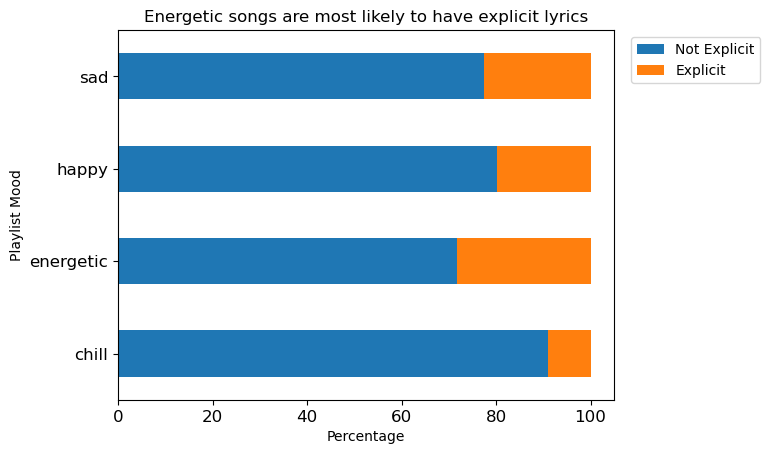

In [337]:
# create stacked bar chart
ax = explicit_df.plot(kind='barh', stacked=True)
ax.set_xlabel('Percentage')
ax.set_ylabel('Playlist Mood')
ax.legend(['Not Explicit', 'Explicit'], bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_title('Energetic songs are most likely to have explicit lyrics')
plt.show()

The bar chart and the percentages above show us that energetic songs have the highest proportion of explicit lyrics, with chilled songs having the least.  Therefore this is likely to contribute to predicting an energetic song.

More unexpectedly, there is not much difference between the prevalence of explicit lyrics in happy vs sad songs.  Perhaps explicit lyrics are used to convey strong happy emotion as well as sad.

**Output the cleaned and pre-processed training dataset**

Our dataset is now ready to be input into modelling.  Save to disk.

In [338]:
joblib.dump(df, "./data/pickles/cleaned_preproc_train_df.pkl")

['./data/pickles/cleaned_preproc_train_df.pkl']

### Applying cleaning and pre-processing to Test Set

Now that we have cleaned and pre-processed the training data, we want to apply the exact same steps to the test set, so that the modelling can be evaluated.

Load the test X and y

In [339]:
df = joblib.load("./data/pickles/X_test_raw.pkl")
y_test = joblib.load("./data/pickles/y_test_raw.pkl")

Apply cleaning and pre-processing steps

In [340]:
print(f"There are {df.shape[0]} rows")
print("Checking initial NaNs")
print_NANs(df)
print("---")
print("Dealing with NaNs")
#drop nan artists
df = df[
    df['artists'].notna()
]

#drop nan tracks
df = df[
    df['track_name'].notna()
]

# fill nan playlist names with query name
df['playlist_name'].fillna(df['query'], inplace=True)

df = df.fillna("[]")

print("Checking NaNs again")
print_NANs(df)

# lower case all playlist names for ease of cleaning
df['playlist_name'] = df['playlist_name'].apply(str.lower)

# define custom function to compare row by row whether an artist name is same as a query
def artist_contains_query(row):
    return (row['query'] in row['artists'].lower()) and (row['query'] in row['playlist_name'])

# apply the custom function
q_artist = df[df.apply(artist_contains_query, axis=1)]

print(f"There are {q_artist.shape[0]} tracks where the query is in the artist name")

df = df[
    ~(df.apply(artist_contains_query, axis=1))
]

#define custom function to compare row by row whether an artist name is in the playlist name, but not in the query

def playlist_contains_artist_not_query(row):
    return ((row['artists'].lower() in row['playlist_name']) & (row['query'] not in row['playlist_name']))

# apply custom function to each row of the DataFrame
pl_artist_not_query = df[df.apply(playlist_contains_artist_not_query, axis=1)]

print(f"There are {pl_artist_not_query.shape[0]} tracks where the artist is in the Playlist name, but not in the query")

#drop all rows where artist is in playlist name but query is not
df = df[
    ~(df.apply(playlist_contains_artist_not_query, axis=1))
]

def this_is_identifier(row):
    return (("this is" in row['playlist_name']))

pl_this_is = df[
    (df.apply(this_is_identifier, axis=1))
]

print(f"There are {pl_this_is.shape[0]} tracks with 'This is...' in the playlist name")

df = df[
    ~(df.apply(this_is_identifier, axis=1))
]

rows_before = df.shape[0]

# remove 'lovely' instead of 'lively' playlists
df = df[
    ~((df['playlist_name'].str.contains('lovely')) & (df['query']=='lively'))
]

rows_after = df.shape[0]
print(f"Lovely not lively: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'heavy rain' playlists
df = df[
    ~((df['playlist_name'].str.contains('heavy rain')))
]

rows_after = df.shape[0]
print(f"Heavy rain: Removed {rows_before - rows_after}")
rows_before = rows_after


# # remove anti-depression playlists where query is 'depress'
df = df[
    ~(((df['playlist_name'].str.contains('anti-d')) | (df['playlist_name'].str.contains('anti d'))) & (df['query']=='depress'))
]

rows_after = df.shape[0]
print(f"Anti-depression in depress: Removed {rows_before - rows_after}")
rows_before = rows_after


# # remove playlists that are referring to 'less' of the query e.g. 'less heavy'
df = df[
    ~(df['playlist_name'].str.contains('less'))
]

rows_after = df.shape[0]
print(f"Less heavy: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'sadar bahar' returned with 'sad'
df = df[
    ~((df['playlist_name'].str.contains('sadar bahar')) & (df['query']=='sad'))
]

rows_after = df.shape[0]
print(f"Sadar bahar: Removed {rows_before - rows_after}")
rows_before = rows_after


# remove playlists that are 'positive affirmations' from 'positive' query
df = df[
    ~((df['playlist_name'].str.contains('positive affirmation')) & (df['query']=='positive'))
]

rows_after = df.shape[0]
print(f"Positive affirmations: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove playlists with 'negative' query as these generally don't fit the mood, e.g. negative space or negative rizz
df = df[
    ~(df['query']=='negative')
]

rows_after = df.shape[0]
print(f"Negative query: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove playlists with 'Selena Gomez - Calm Down' from 'calm' query
df = df[
    ~((df['playlist_name'].str.contains('selena gomez')) & (df['query']=='calm'))
]

rows_after = df.shape[0]
print(f"Selena Gomez calm down: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'softball' playlists from 'soft' query
df = df[
    ~((df['playlist_name'].str.contains('softball')) & (df['query']=='soft'))
]

rows_after = df.shape[0]
print(f"Softball in soft: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'Blackpink' playlists from 'happiest' query (they have a sad song called 'Happiest Girl')
df = df[
    ~((df['playlist_name'].str.contains('happiest girl')) & (df['query']=='happiest'))
]

rows_after = df.shape[0]
print(f"Blackpink in happiest: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'dynamic' playlists, which are generally unsuitable as a query\
#  e.g. 'dynamic duo' playlists named after the creators, or 'dynamic sleep' and 'dynamic yoga'
df = df[
    ~(df['query']=='dynamic')
]

rows_after = df.shape[0]
print(f"Dynamic: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove playlist 'euphoric destruction', which is a large 389 song playlist \
# that contains heavy metal, some of which is the opposite of happy 
df = df[
    ~((df['playlist_name'].str.contains('destruction')) & (df['query']=='euphoric'))
]

rows_after = df.shape[0]
print(f"Euphoric destruction: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'sunny' query, as it has only returned songs from a movie or related to the location 'sunny beach'

df = df[
    ~(df['query']=='sunny')
]

rows_after = df.shape[0]
print(f"Sunny: Removed {rows_before - rows_after}")
rows_before = rows_after



df['artist_genre'] = df['artist_genre'].astype(str)

# get genre as a series
genre = df['artist_genre']

# split into a list using the comma
genre_split = genre.str.split(", ")

#strip out unwanted characters
new_genre_list = []

for artist in genre_split:
    strippedgenre = []
    for genre in artist:
        strippedgenre.append((re.sub(r'[^\w]', ' ', genre)).strip())
    new_genre_list.append(strippedgenre)

genre_counts = {}  # dictionary to keep track of genre counters

for genres in new_genre_list:
    # create a Counter for the current list of genres
    current_genre_count = Counter(genres)

    for genre, count in current_genre_count.items():
        # update the corresponding counter for the genre in the dictionary
        if genre in genre_counts:
            genre_counts[genre] += count
        else:
            genre_counts[genre] = count

print(f"There are {len(genre_counts)} different genres in the dataset")

sorted_by_genre = sorted(genre_counts.items(), key=lambda x:x[1], reverse=True)

sorted_by_genre.pop(0)

# the list of keywords was initially chosen with a smaller set, and was added to iteratively \
# as more category options were found that end up in 'other'

rocklist = ['rock','alt z', 'punk', 'grunge', 'indie', 'guitar', 'weirdcore']
metallist = ['metal', 'emo', 'hardcore', 'screamo', 'death', 'slayer']
folklist = ['country', 'folk', 'llywood', 'ccm', 'filmi', 'kirtan', 'sad sierreno',
            'mexicana', 'worship', 'afrofuturism', 'americana', 'fingerstyle', 'salsa',
            'musica']
poplist = ['pop', 'songwriter', 'stomp and holler', 'neo mellow', 'sped up', 'a cappella']
electroniclist = ['edm', 'house', 'dance', 'trance', 'tech','bass','electro', 
                  'rave', 'tronica', 'new french touch', 'beats', 'neo mellow',
                  'psych', 'hardstyle', 'rawstyle', 'dnb', 'frenchcore', 'tekk',
                  'phonk', 'breakcore', 'otacore', 'glitch', 'dubstep', 'chillwave']
soullist = ['soul', 'funk', 'r b', 'motown', 'jazz', 'quiet storm', 'reggae', 'disco',
            'r&b', 'adult standards', 'gospel', 'high vibe', 'lo fi']
raplist = ['rap', 'hop', 'trap', 'drill', 'pluggnb', 'gymcore']
instrumentallist = ['classical', 'meditation', 'background', 'orchestral', 'soundtrack', 
                    'ambient', 'sleep', 'instrumental', 'pet calming','vgm', 'pixel', 
                    'piano cover', 'video game music', 'classify', 'pink noise', 
                    'movie tunes', 'piano', 'ukulele', 'orchestra']

#instantiate new list and genre dictionary with counts
grouped_genre_list = []
for artist in new_genre_list:
    genre_counts = {
    'rock': 0,
    'metal': 0,
    'folk': 0,
    'pop': 0,
    'electronic': 0,
    'soul': 0,
    'rap': 0,
    'instrumental': 0,
    'other': 0
    }

# count the genres for each artist and update the dictionary with a counter
    for genre in artist:

        if any(keyword in genre for keyword in rocklist):
            genre_counts['rock'] += 1
        if any(keyword in genre for keyword in metallist):
            genre_counts['metal'] += 1
        if any(keyword in genre for keyword in folklist):
            genre_counts['folk'] += 1
        elif any(keyword in genre for keyword in raplist):
            genre_counts['rap'] += 1
        elif any(keyword in genre for keyword in electroniclist):
            genre_counts['electronic'] += 1
        elif any(keyword in genre for keyword in soullist):
            genre_counts['soul'] += 1
        elif any(keyword in genre for keyword in poplist):
            genre_counts['pop'] += 1
        elif any(keyword in genre for keyword in instrumentallist):
            genre_counts['instrumental'] += 1
        else:
            genre_counts['other'] += 0.1  # give 'unknown' a lower weighting

    # sort the dictionary by values in descending order
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

    # top genre is the first key in the sorted dict, except in the case of a tie,\
    #  in which case the winner is chosen at random from the top scorers
    matching_indices = [0]

    for i in range(1, len(sorted_genres)):
        if sorted_genres[i][1] == sorted_genres[0][1]:
            matching_indices.append(i)
    random.seed(666)
    chosen_index = random.choice(matching_indices)

    max_genre = sorted_genres[chosen_index][0]

    # add genre to the list for that artist
    grouped_genre_list.append(max_genre)

# add as new df column and drop the original
df['grouped_genres'] = grouped_genre_list

print("Sorted genres into wider categories")
print("---")
print_value_counts(df, "grouped_genres")
print("Converting genre to dummies and drop original columns")


# convert genres into dummies and drop original
genre_dummies = pd.get_dummies(df['grouped_genres'], prefix="genre")
df = pd.concat([df, genre_dummies], axis=1)

df.drop(columns='grouped_genres', inplace=True)
df.drop(columns="artist_genre", inplace=True)

print("Winsorizing duration_ms to a max of 707600")
df['duration_ms'] = df['duration_ms'].apply(lambda x: min(x, 707600))

print("Engineering 'common_time' feature and dropping 'time_signature'")
# map to common or not common time

df["common_time"] = df["time_signature"].map(
    {
        4: 1,
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        5: 0,
        
    }
)


df.drop(columns='time_signature', inplace=True)

print("Pre-process 'key' column and create dummies")
# convert key column to actual key so it is more interpretable before creating dummies
df["key_sig"] = df["key"].map(
    {
        0: 'C',
        1: 'Db',
        2: 'D',
        3: 'Eb',
        4: 'E',
        5: 'F', 
        6: 'Gb',
        7: 'G',
        8: 'Ab',
        9: 'A',
        10: 'Bb',
        11: 'B'
        
       
    }
)
# convert key into dummies and drop originals
key_dummies = pd.get_dummies(df['key_sig'], prefix="key")
df = pd.concat([df, key_dummies], axis=1)

df.drop(columns=['key', 'key_sig'], inplace=True)

print("Binarize 'explicit' column")
# set the explicit tag true or false to a 1 or 0
df["explicit"] = df["explicit"].astype(int)

print("Completed cleaning and pre-processing on test-set")


There are 32093 rows
Checking initial NaNs
track_name has 33 NaNs
artists has 33 NaNs
artist_genre has 3 NaNs
playlist_name has 146 NaNs
---
Dealing with NaNs
Checking NaNs again
There are no NaN values
There are 1185 tracks where the query is in the artist name
There are 810 tracks where the artist is in the Playlist name, but not in the query
There are 305 tracks with 'This is...' in the playlist name
Lovely not lively: Removed 350
Heavy rain: Removed 46
Anti-depression in depress: Removed 103
Less heavy: Removed 90
Sadar bahar: Removed 48
Positive affirmations: Removed 69
Negative query: Removed 898
Selena Gomez calm down: Removed 12
Softball in soft: Removed 29
Blackpink in happiest: Removed 6
Dynamic: Removed 1145
Euphoric destruction: Removed 74
Sunny: Removed 21
There are 2634 different genres in the dataset
Sorted genres into wider categories
---
Dataset contains 4824 other songs
Dataset contains 4806 rap songs
Dataset contains 3803 pop songs
Dataset contains 3558 electronic so

Check number of rows

In [341]:
print(df.shape)
print(y_test.shape)

(26869, 40)
(32093,)


After cleaning and dropping df and y_test have different number of rows.  Let's perform an inner join to combine them, i.e. dropping the same y_test rows

In [342]:
#  and reset the index
df = df.join(y_test, how='inner').reset_index(drop=True)

In [343]:
joblib.dump(df, "./data/pickles/cleaned_preproc_test_df.pkl")

['./data/pickles/cleaned_preproc_test_df.pkl']

#### Pre-process Complete Dataset

For future use, let's also apply the pre-processing steps to the complete dataset.

In [344]:
df = joblib.load("./data/pickles/df_full_raw.pkl")

In [345]:
print(f"There are {df.shape[0]} rows")
print("Checking initial NaNs")
print_NANs(df)
print("---")
print("Dealing with NaNs")
#drop nan artists
df = df[
    df['artists'].notna()
]

#drop nan tracks
df = df[
    df['track_name'].notna()
]

# fill nan playlist names with query name
df['playlist_name'].fillna(df['query'], inplace=True)

df = df.fillna("[]")

print("Checking NaNs again")
print_NANs(df)

# lower case all playlist names for ease of cleaning
df['playlist_name'] = df['playlist_name'].apply(str.lower)

# define custom function to compare row by row whether an artist name is same as a query
def artist_contains_query(row):
    return (row['query'] in row['artists'].lower()) and (row['query'] in row['playlist_name'])

# apply the custom function
q_artist = df[df.apply(artist_contains_query, axis=1)]

print(f"There are {q_artist.shape[0]} tracks where the query is in the artist name")

df = df[
    ~(df.apply(artist_contains_query, axis=1))
]

#define custom function to compare row by row whether an artist name is in the playlist name, but not in the query

def playlist_contains_artist_not_query(row):
    return ((row['artists'].lower() in row['playlist_name']) & (row['query'] not in row['playlist_name']))

# apply custom function to each row of the DataFrame
pl_artist_not_query = df[df.apply(playlist_contains_artist_not_query, axis=1)]

print(f"There are {pl_artist_not_query.shape[0]} tracks where the artist is in the Playlist name, but not in the query")

#drop all rows where artist is in playlist name but query is not
df = df[
    ~(df.apply(playlist_contains_artist_not_query, axis=1))
]

def this_is_identifier(row):
    return (("this is" in row['playlist_name']))

pl_this_is = df[
    (df.apply(this_is_identifier, axis=1))
]

print(f"There are {pl_this_is.shape[0]} tracks with 'This is...' in the playlist name")

df = df[
    ~(df.apply(this_is_identifier, axis=1))
]

rows_before = df.shape[0]

# remove 'lovely' instead of 'lively' playlists
df = df[
    ~((df['playlist_name'].str.contains('lovely')) & (df['query']=='lively'))
]

rows_after = df.shape[0]
print(f"Lovely not lively: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'heavy rain' playlists
df = df[
    ~((df['playlist_name'].str.contains('heavy rain')))
]

rows_after = df.shape[0]
print(f"Heavy rain: Removed {rows_before - rows_after}")
rows_before = rows_after


# # remove anti-depression playlists where query is 'depress'
df = df[
    ~(((df['playlist_name'].str.contains('anti-d')) | (df['playlist_name'].str.contains('anti d'))) & (df['query']=='depress'))
]

rows_after = df.shape[0]
print(f"Anti-depression in depress: Removed {rows_before - rows_after}")
rows_before = rows_after


# # remove playlists that are referring to 'less' of the query e.g. 'less heavy'
df = df[
    ~(df['playlist_name'].str.contains('less'))
]

rows_after = df.shape[0]
print(f"Less heavy: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'sadar bahar' returned with 'sad'
df = df[
    ~((df['playlist_name'].str.contains('sadar bahar')) & (df['query']=='sad'))
]

rows_after = df.shape[0]
print(f"Sadar bahar: Removed {rows_before - rows_after}")
rows_before = rows_after


# remove playlists that are 'positive affirmations' from 'positive' query
df = df[
    ~((df['playlist_name'].str.contains('positive affirmation')) & (df['query']=='positive'))
]

rows_after = df.shape[0]
print(f"Positive affirmations: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove playlists with 'negative' query as these generally don't fit the mood, e.g. negative space or negative rizz
df = df[
    ~(df['query']=='negative')
]

rows_after = df.shape[0]
print(f"Negative query: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove playlists with 'Selena Gomez - Calm Down' from 'calm' query
df = df[
    ~((df['playlist_name'].str.contains('selena gomez')) & (df['query']=='calm'))
]

rows_after = df.shape[0]
print(f"Selena Gomez calm down: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'softball' playlists from 'soft' query
df = df[
    ~((df['playlist_name'].str.contains('softball')) & (df['query']=='soft'))
]

rows_after = df.shape[0]
print(f"Softball in soft: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'Blackpink' playlists from 'happiest' query (they have a sad song called 'Happiest Girl')
df = df[
    ~((df['playlist_name'].str.contains('happiest girl')) & (df['query']=='happiest'))
]

rows_after = df.shape[0]
print(f"Blackpink in happiest: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'dynamic' playlists, which are generally unsuitable as a query\
#  e.g. 'dynamic duo' playlists named after the creators, or 'dynamic sleep' and 'dynamic yoga'
df = df[
    ~(df['query']=='dynamic')
]

rows_after = df.shape[0]
print(f"Dynamic: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove playlist 'euphoric destruction', which is a large 389 song playlist \
# that contains heavy metal, some of which is the opposite of happy 
df = df[
    ~((df['playlist_name'].str.contains('destruction')) & (df['query']=='euphoric'))
]

rows_after = df.shape[0]
print(f"Euphoric destruction: Removed {rows_before - rows_after}")
rows_before = rows_after

# remove 'sunny' query, as it has only returned songs from a movie or related to the location 'sunny beach'

df = df[
    ~(df['query']=='sunny')
]

rows_after = df.shape[0]
print(f"Sunny: Removed {rows_before - rows_after}")
rows_before = rows_after

df['artist_genre'] = df['artist_genre'].astype(str)

# get genre as a series
genre = df['artist_genre']

# split into a list using the comma
genre_split = genre.str.split(", ")

#strip out unwanted characters
new_genre_list = []

for artist in genre_split:
    strippedgenre = []
    for genre in artist:
        strippedgenre.append((re.sub(r'[^\w]', ' ', genre)).strip())
    new_genre_list.append(strippedgenre)

genre_counts = {}  # dictionary to keep track of genre counters

for genres in new_genre_list:
    # create a Counter for the current list of genres
    current_genre_count = Counter(genres)

    for genre, count in current_genre_count.items():
        # update the corresponding counter for the genre in the dictionary
        if genre in genre_counts:
            genre_counts[genre] += count
        else:
            genre_counts[genre] = count

print(f"There are {len(genre_counts)} different genres in the dataset")

sorted_by_genre = sorted(genre_counts.items(), key=lambda x:x[1], reverse=True)

sorted_by_genre.pop(0)

# the list of keywords was initially chosen with a smaller set, and was added to iteratively \
# as more category options were found that end up in 'other'

rocklist = ['rock','alt z', 'punk', 'grunge', 'indie', 'guitar', 'weirdcore']
metallist = ['metal', 'emo', 'hardcore', 'screamo', 'death', 'slayer']
folklist = ['country', 'folk', 'llywood', 'ccm', 'filmi', 'kirtan', 'sad sierreno',
            'mexicana', 'worship', 'afrofuturism', 'americana', 'fingerstyle', 'salsa',
            'musica']
poplist = ['pop', 'songwriter', 'stomp and holler', 'neo mellow', 'sped up', 'a cappella']
electroniclist = ['edm', 'house', 'dance', 'trance', 'tech','bass','electro', 
                  'rave', 'tronica', 'new french touch', 'beats', 'neo mellow',
                  'psych', 'hardstyle', 'rawstyle', 'dnb', 'frenchcore', 'tekk',
                  'phonk', 'breakcore', 'otacore', 'glitch', 'dubstep', 'chillwave']
soullist = ['soul', 'funk', 'r b', 'motown', 'jazz', 'quiet storm', 'reggae', 'disco',
            'r&b', 'adult standards', 'gospel', 'high vibe', 'lo fi']
raplist = ['rap', 'hop', 'trap', 'drill', 'pluggnb', 'gymcore']
instrumentallist = ['classical', 'meditation', 'background', 'orchestral', 'soundtrack', 
                    'ambient', 'sleep', 'instrumental', 'pet calming','vgm', 'pixel', 
                    'piano cover', 'video game music', 'classify', 'pink noise', 
                    'movie tunes', 'piano', 'ukulele', 'orchestra']

#instantiate new list and genre dictionary with counts
grouped_genre_list = []
for artist in new_genre_list:
    genre_counts = {
    'rock': 0,
    'metal': 0,
    'folk': 0,
    'pop': 0,
    'electronic': 0,
    'soul': 0,
    'rap': 0,
    'instrumental': 0,
    'other': 0
    }

# count the genres for each artist and update the dictionary with a counter
    for genre in artist:

        if any(keyword in genre for keyword in rocklist):
            genre_counts['rock'] += 1
        if any(keyword in genre for keyword in metallist):
            genre_counts['metal'] += 1
        if any(keyword in genre for keyword in folklist):
            genre_counts['folk'] += 1
        elif any(keyword in genre for keyword in raplist):
            genre_counts['rap'] += 1
        elif any(keyword in genre for keyword in electroniclist):
            genre_counts['electronic'] += 1
        elif any(keyword in genre for keyword in soullist):
            genre_counts['soul'] += 1
        elif any(keyword in genre for keyword in poplist):
            genre_counts['pop'] += 1
        elif any(keyword in genre for keyword in instrumentallist):
            genre_counts['instrumental'] += 1
        else:
            genre_counts['other'] += 0.1  # give 'unknown' a lower weighting

    # sort the dictionary by values in descending order
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

    # top genre is the first key in the sorted dict, except in the case of a tie,\
    #  in which case the winner is chosen at random from the top scorers
    matching_indices = [0]

    for i in range(1, len(sorted_genres)):
        if sorted_genres[i][1] == sorted_genres[0][1]:
            matching_indices.append(i)
    random.seed(666)
    chosen_index = random.choice(matching_indices)

    max_genre = sorted_genres[chosen_index][0]

    # add genre to the list for that artist
    grouped_genre_list.append(max_genre)

# add as new df column and drop the original
df['grouped_genres'] = grouped_genre_list

print("Sorted genres into wider categories")
print("---")
print_value_counts(df, "grouped_genres")
print("Converting genre to dummies and drop original columns")


# convert genres into dummies and drop original
genre_dummies = pd.get_dummies(df['grouped_genres'], prefix="genre")
df = pd.concat([df, genre_dummies], axis=1)

#df.drop(columns='grouped_genres', inplace=True) # keep grouped genre for later analysis
df.drop(columns="artist_genre", inplace=True)

print("Winsorizing duration_ms to a max of 707600")
df['duration_ms'] = df['duration_ms'].apply(lambda x: min(x, 707600))

print("Engineering 'common_time' feature and dropping 'time_signature'")
# map to common or not common time

df["common_time"] = df["time_signature"].map(
    {
        4: 1,
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        5: 0,
        
    }
)


df.drop(columns='time_signature', inplace=True)

print("Pre-process 'key' column and create dummies")
# convert key column to actual key so it is more interpretable before creating dummies
df["key_sig"] = df["key"].map(
    {
        0: 'C',
        1: 'Db',
        2: 'D',
        3: 'Eb',
        4: 'E',
        5: 'F', 
        6: 'Gb',
        7: 'G',
        8: 'Ab',
        9: 'A',
        10: 'Bb',
        11: 'B'
        
       
    }
)
# convert key into dummies and drop originals
key_dummies = pd.get_dummies(df['key_sig'], prefix="key")
df = pd.concat([df, key_dummies], axis=1)

df.drop(columns=['key', 'key_sig'], inplace=True)

print("Binarize 'explicit' column")
# set the explicit tag true or false to a 1 or 0
df["explicit"] = df["explicit"].astype(int)

print("Completed cleaning and pre-processing")


There are 160465 rows
Checking initial NaNs
track_name has 180 NaNs
artists has 179 NaNs
artist_genre has 15 NaNs
playlist_name has 693 NaNs
---
Dealing with NaNs
Checking NaNs again
There are no NaN values
There are 6148 tracks where the query is in the artist name
There are 4178 tracks where the artist is in the Playlist name, but not in the query
There are 1499 tracks with 'This is...' in the playlist name
Lovely not lively: Removed 1764
Heavy rain: Removed 218
Anti-depression in depress: Removed 512
Less heavy: Removed 456
Sadar bahar: Removed 255
Positive affirmations: Removed 330
Negative query: Removed 4626
Selena Gomez calm down: Removed 63
Softball in soft: Removed 151
Blackpink in happiest: Removed 23
Dynamic: Removed 5582
Euphoric destruction: Removed 302
Sunny: Removed 136
There are 3620 different genres in the dataset
Sorted genres into wider categories
---
Dataset contains 24679 other songs
Dataset contains 23707 rap songs
Dataset contains 19012 pop songs
Dataset contains

In [346]:
joblib.dump(df, "./data/pickles/cleaned_preproc_full_df.pkl")

['./data/pickles/cleaned_preproc_full_df.pkl']